# DQN on Cartpole


- Deep learning is used to solve the problem of feature representation for large state action pairs


Network:
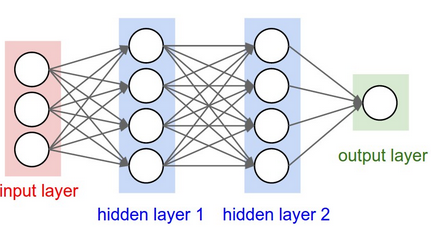

For the input nodes, each node can represent parts of states:

- 1: cart position
- 2: cart velocity
- 3: pole angle
- 4: pole rotation velocity

Loss function:

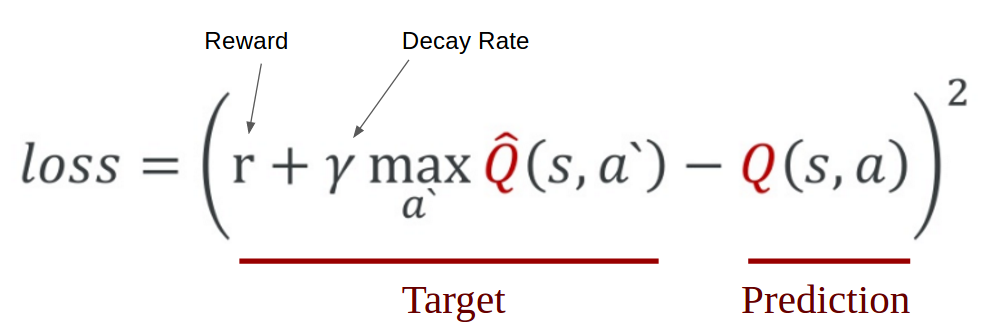

The loss function is represented by squared error between target and past table value.

(more specifically, we use Huber function instead of squared error).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DQN.mp4')
    display(display_animation(anim, default_mode='loop'))

In [4]:
from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('A', 100)

print(Tr_object)
print(Tr_object.value_b)

tr(name_a='A', value_b=100)
100


In [5]:
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [7]:
class ReplayMemory:
    '''Memory for experience replay'''

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0

    def push(self, state, action, state_next, reward):
        '''save transition = (state, action, state_next, reward)'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # append if not full

        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # update index

    def sample(self, batch_size):
        '''sample batch_size amount of random transitions'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''length of memory'''
        return len(self.memory)

In [8]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # set actions

        # initialize memory and set capacity of the memory
        self.memory = ReplayMemory(CAPACITY)

        # Network
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)

        # optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Learn the network parameters using Experience Replay'''

        # -----------------------------------------
        # 1. Memory
        # -----------------------------------------
        # 1.1 If memory size is smaller than the batch size, don't do anything
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. Create minibatch
        # -----------------------------------------
        # 2.1 Get data from memory (#=batch_size)
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 Transform the transitions to batch
        # 1step: (state, action, state_next, reward)
        # all: (state, action, state_next, reward)×BATCH_SIZE
        # 
        # batch: (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # 2.3 Transform batch so that pytorch can read it
        # example: 
        # For each state, there are BATCH_SIZE amount of [torch.FloatTensor of size 1x4]
        # But we want torch.FloatTensor of size BATCH_SIZEx4
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. Get Q(s_t, a_t)
        # -----------------------------------------
        # 3.1 Change network to evaluation
        self.model.eval()

        # 3.2 Calculate Q(s_t, a_t)
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}

        # *check for next state as well
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        # zeroed
        next_state_values = torch.zeros(BATCH_SIZE)

        # get the best action 
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()
        
        # label data based on best aciton
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. Update parameters
        # -----------------------------------------
        # 4.1 Train mode
        self.model.train()

        # 4.2 Loss function (smooth_l1_loss=Huberloss)
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 Update parameters
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()

    def decide_action(self, state, episode):
        '''Action'''
        # ε-greedy method
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)

        else:
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])

        return action

In [9]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)

    def update_q_function(self):
        '''Update Q-value / network'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''Get next action'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''save to memory'''
        self.brain.memory.push(state, action, state_next, reward)

In [10]:
class Environment:

    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n 
        self.agent = Agent(num_states, num_actions)

        
    def run(self):
        episode_10_list = np.zeros(10)  # mean of 10 consecutive episodes
        complete_episodes = 0  # number of times the agent was able to stand for 195 steps
        episode_final = False
        frames = []

        for episode in range(NUM_EPISODES):
            observation = self.env.reset()

            state = observation
            state = torch.from_numpy(state).type(
                torch.FloatTensor)
            state = torch.unsqueeze(state, 0)

            for step in range(MAX_STEPS):  # 1 episode

                if episode_final is True:
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)

                observation_next, _, done, _ = self.env.step(
                    action.item())


                if done:
                    state_next = None

                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0]) 
                        complete_episodes = 0
                    else:
                        reward = torch.FloatTensor([1.0])
                        complete_episodes = complete_episodes + 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = observation_next
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0)

                # Add to memory
                self.agent.memorize(state, action, state_next, reward)

                # Update based on experience replay
                self.agent.update_q_function()

                # update state
                state = state_next

                if done:
                    print('%d Episode: Finished after %d steps：Mean steps of 10 episodes = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:
                print('10 consecutive success!')
                episode_final = True

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 9 steps：Mean steps of 10 episodes = 0.9
1 Episode: Finished after 11 steps：Mean steps of 10 episodes = 2.0
2 Episode: Finished after 10 steps：Mean steps of 10 episodes = 3.0
3 Episode: Finished after 9 steps：Mean steps of 10 episodes = 3.9
4 Episode: Finished after 11 steps：Mean steps of 10 episodes = 5.0
5 Episode: Finished after 12 steps：Mean steps of 10 episodes = 6.2
6 Episode: Finished after 9 steps：Mean steps of 10 episodes = 7.1
7 Episode: Finished after 10 steps：Mean steps of 10 episodes = 8.1
8 Episode: Finished after 9 steps：Mean steps of 10 episodes = 9.0
9 Episode: Finished after 8 steps：Mean steps of 10 episodes = 9.8
10 Episode: Finished after 10 steps：Mean steps of 10 episodes = 9.9
11 Episode: Finished after 9 steps：Mean

115 Episode: Finished after 200 steps：Mean steps of 10 episodes = 183.8
116 Episode: Finished after 200 steps：Mean steps of 10 episodes = 183.8
117 Episode: Finished after 93 steps：Mean steps of 10 episodes = 173.1
118 Episode: Finished after 180 steps：Mean steps of 10 episodes = 184.5
119 Episode: Finished after 195 steps：Mean steps of 10 episodes = 184.0
120 Episode: Finished after 200 steps：Mean steps of 10 episodes = 186.0
121 Episode: Finished after 166 steps：Mean steps of 10 episodes = 182.6
122 Episode: Finished after 88 steps：Mean steps of 10 episodes = 171.4
123 Episode: Finished after 88 steps：Mean steps of 10 episodes = 161.0
124 Episode: Finished after 83 steps：Mean steps of 10 episodes = 149.3
125 Episode: Finished after 70 steps：Mean steps of 10 episodes = 136.3
126 Episode: Finished after 82 steps：Mean steps of 10 episodes = 124.5
127 Episode: Finished after 53 steps：Mean steps of 10 episodes = 120.5
128 Episode: Finished after 55 steps：Mean steps of 10 episodes = 108.0



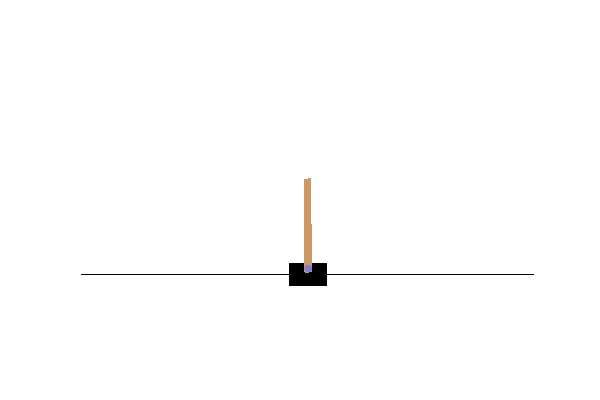
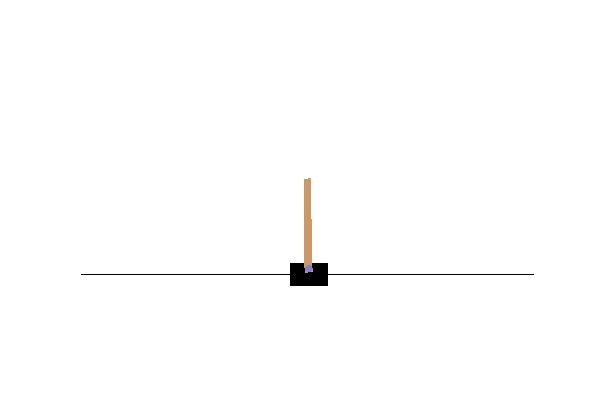
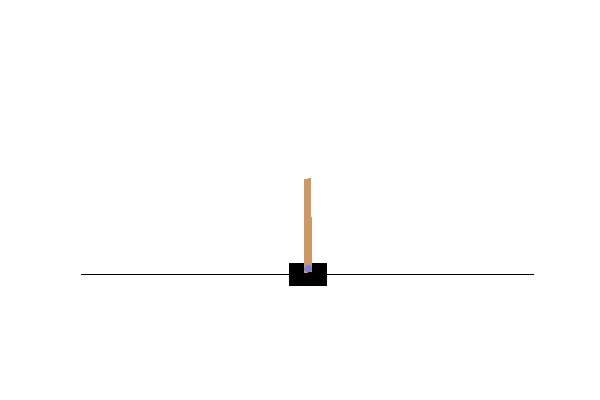
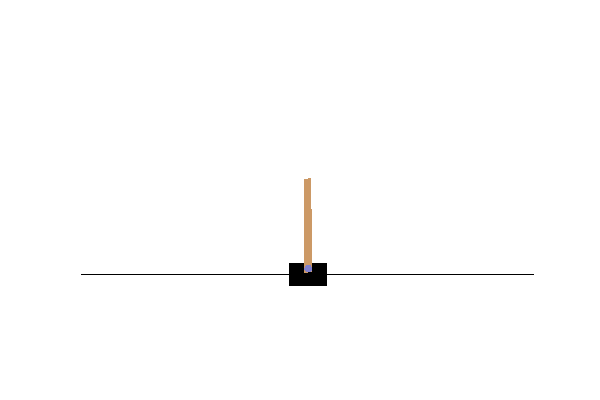
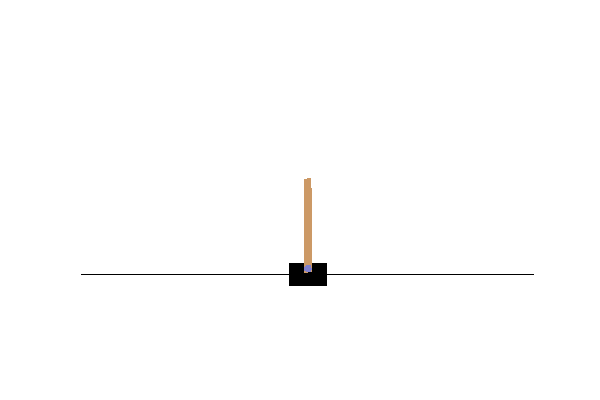
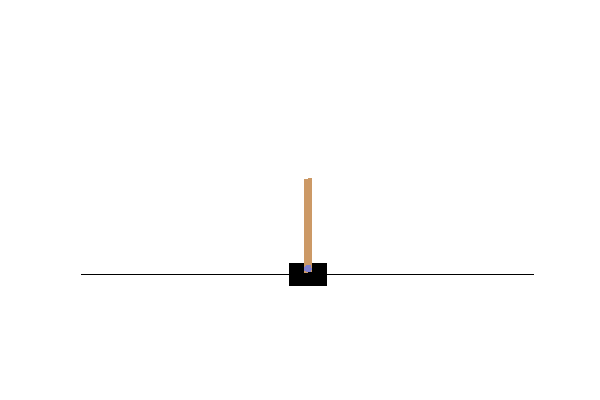
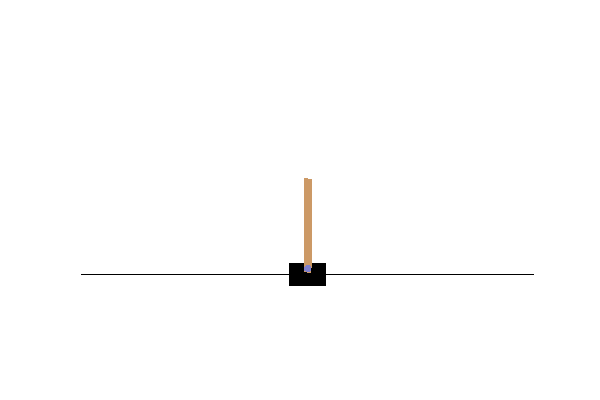
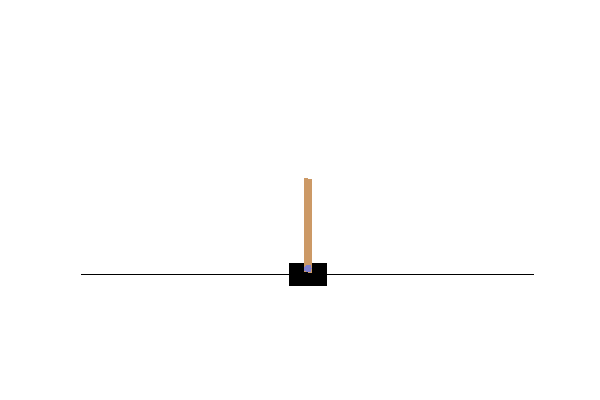
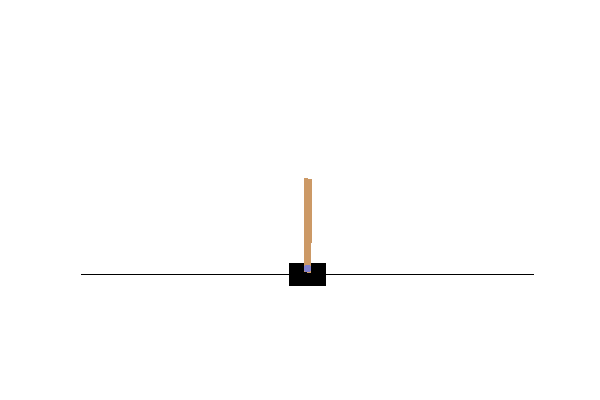
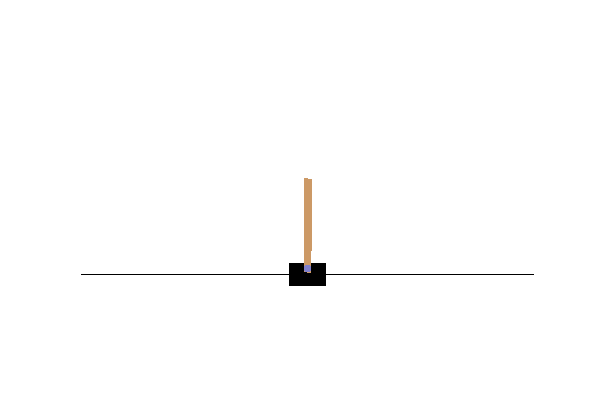
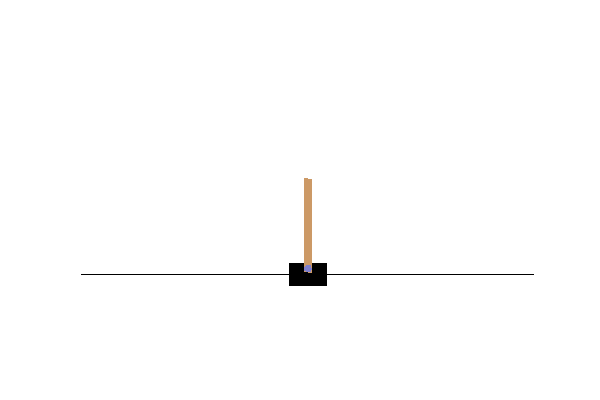
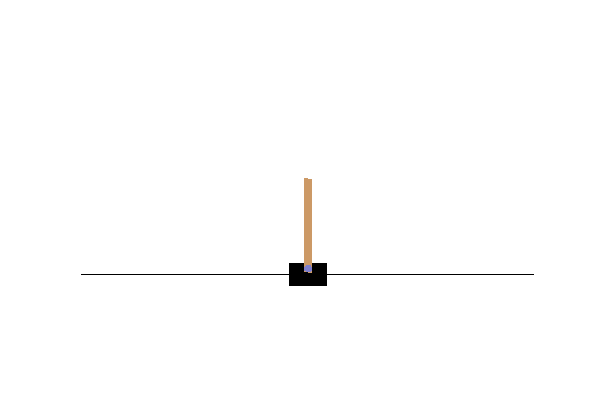
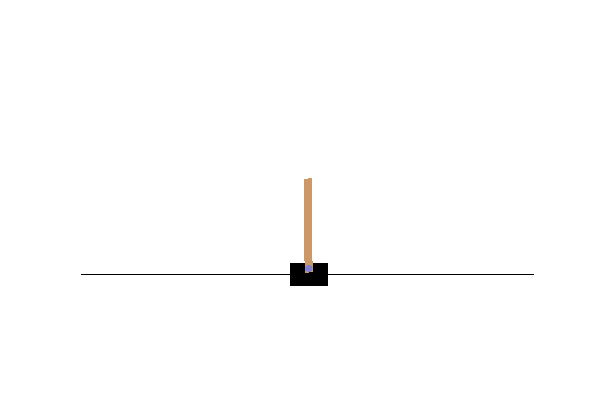
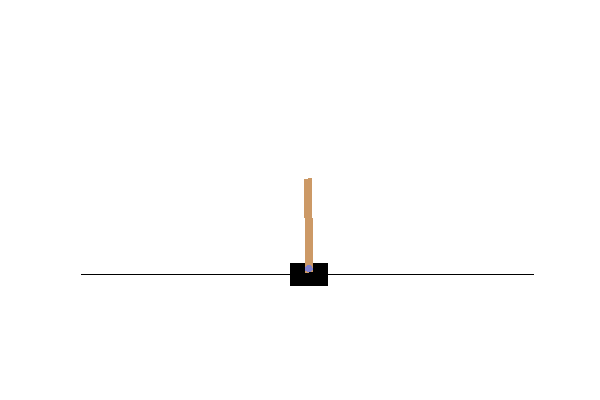
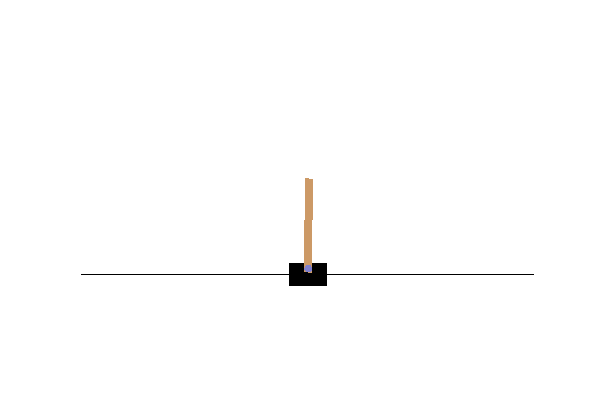
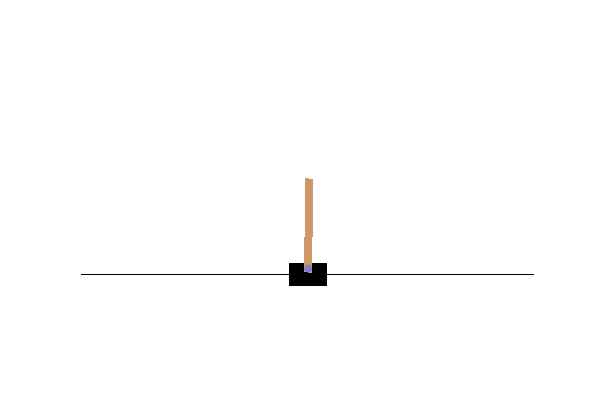
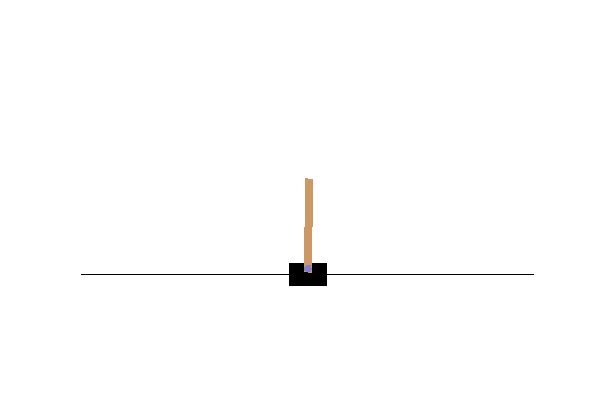
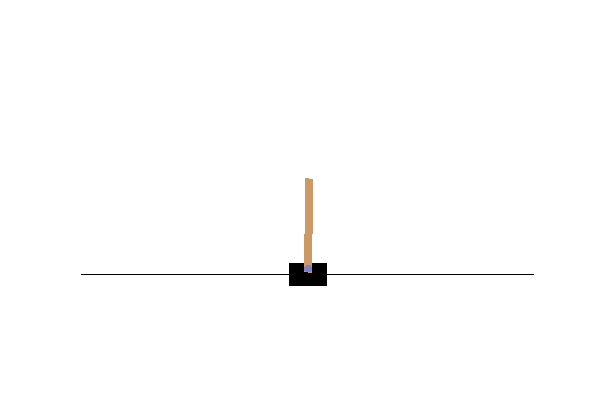
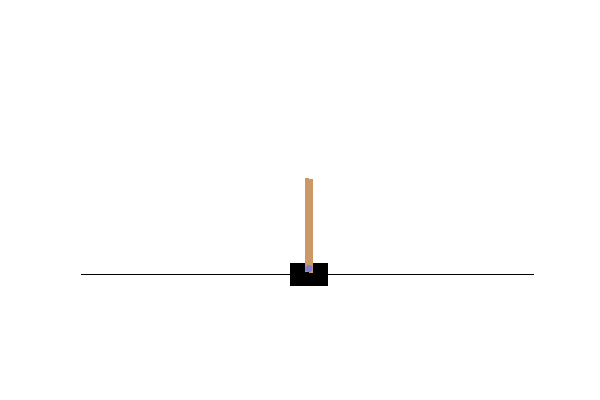
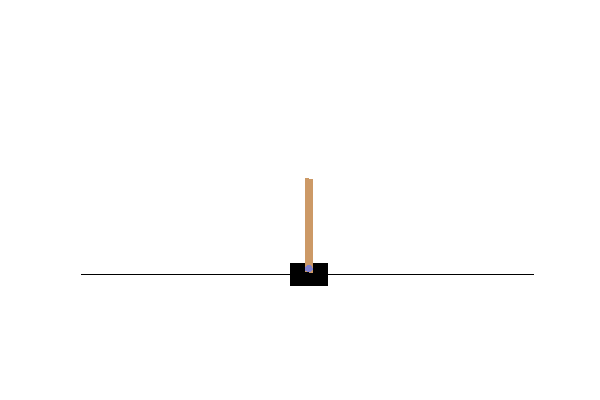
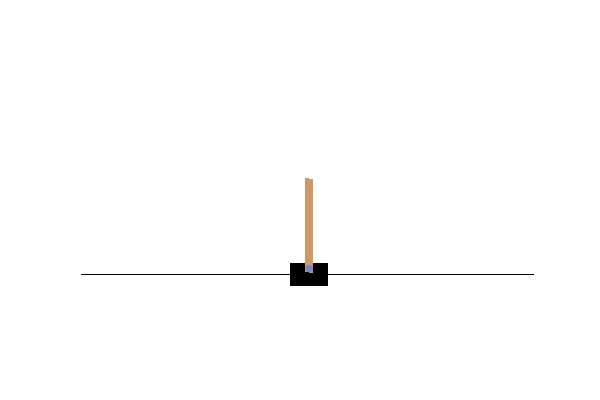
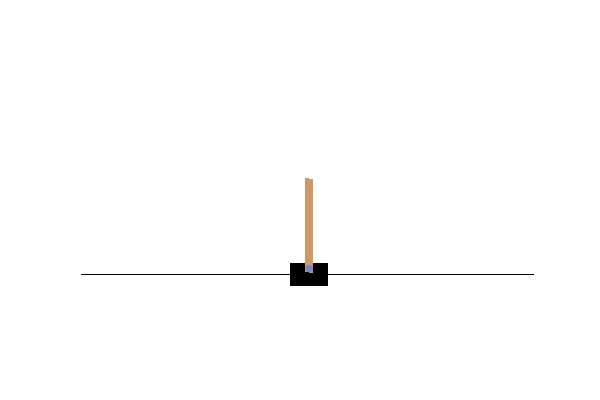
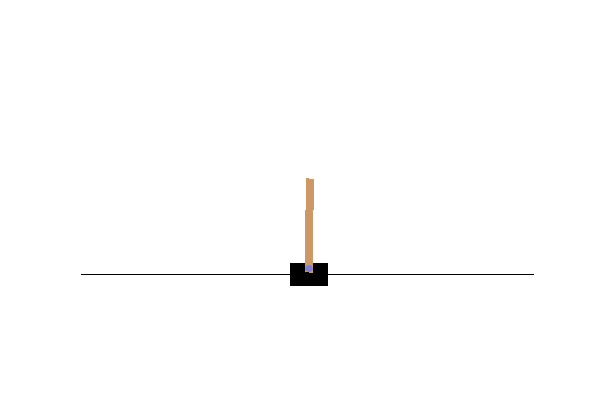
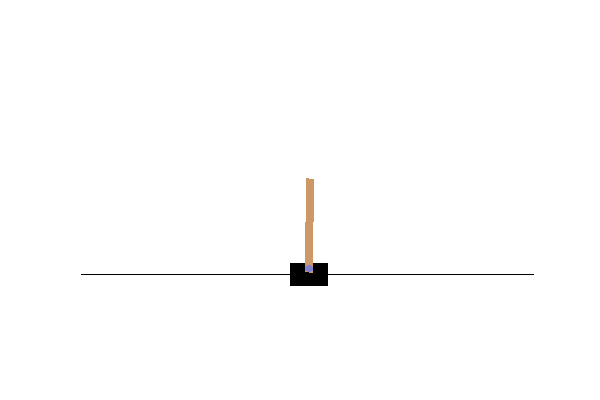
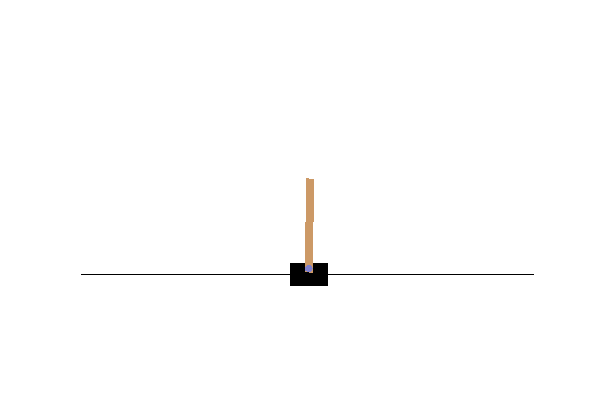
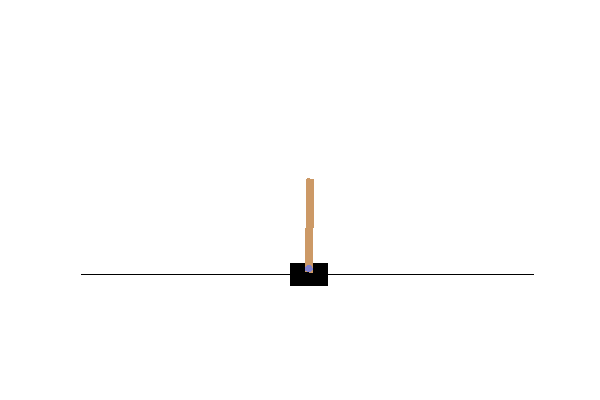
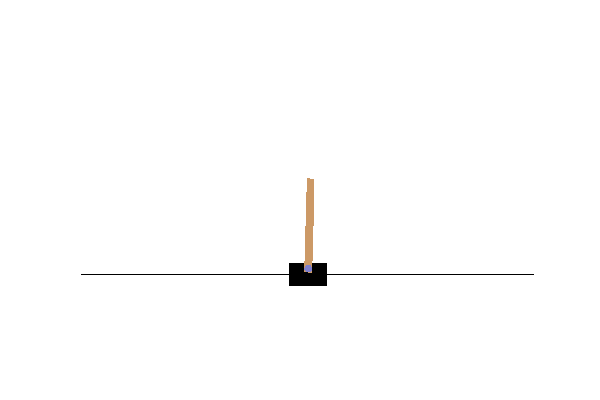
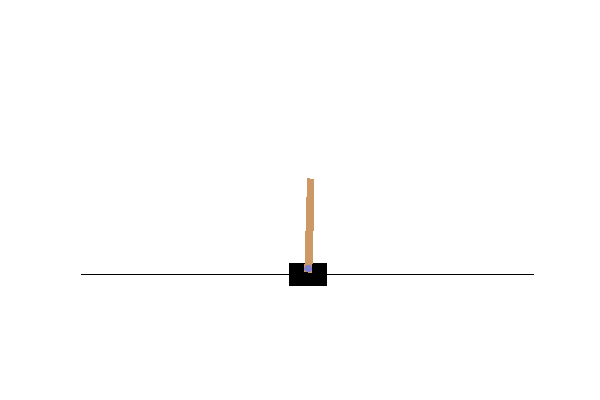
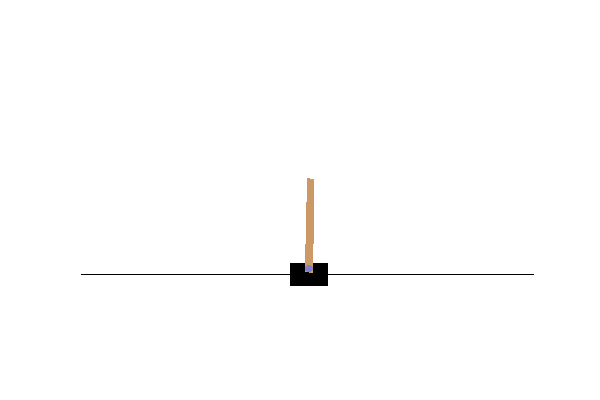
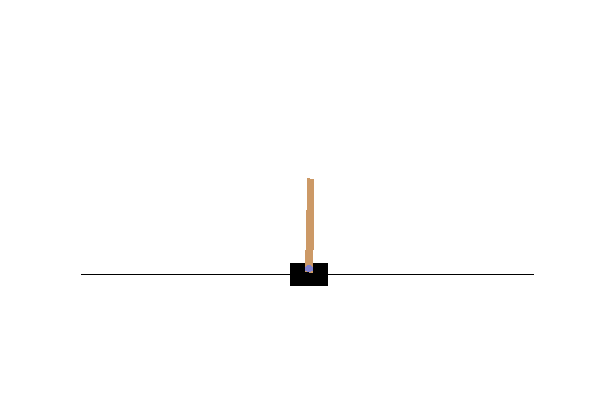
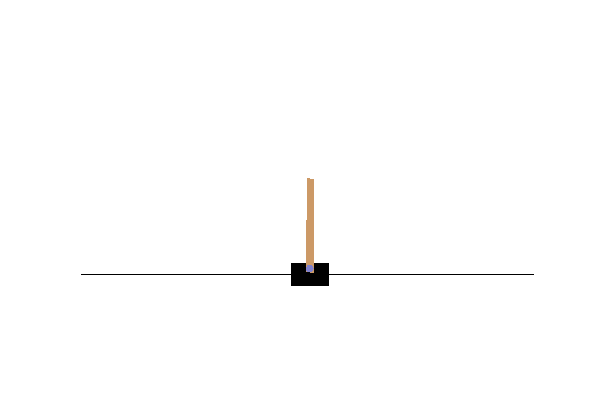
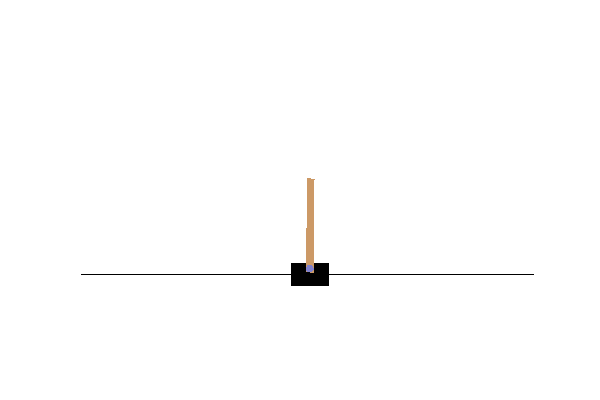
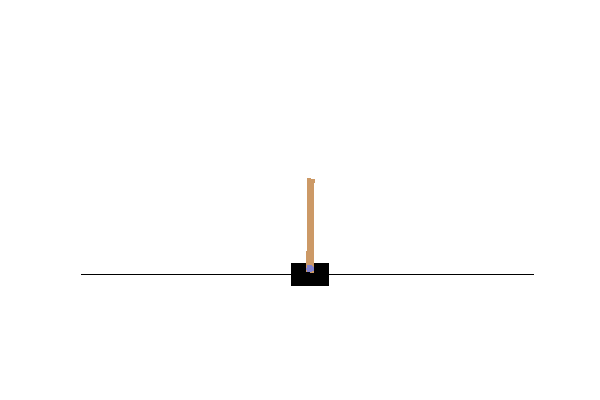
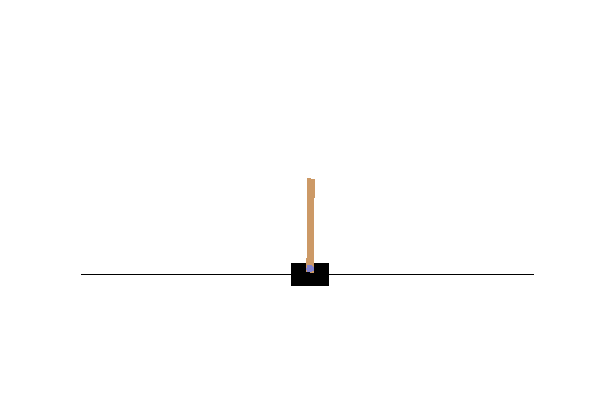
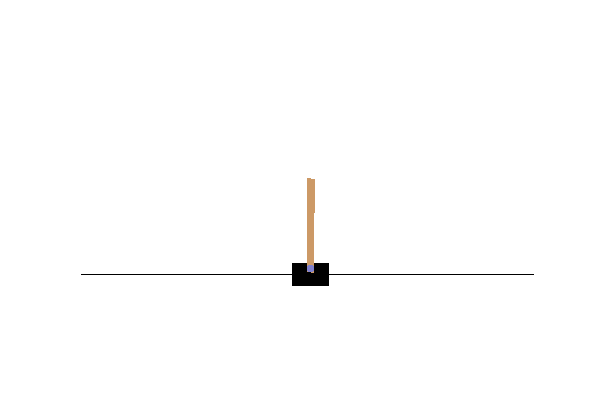
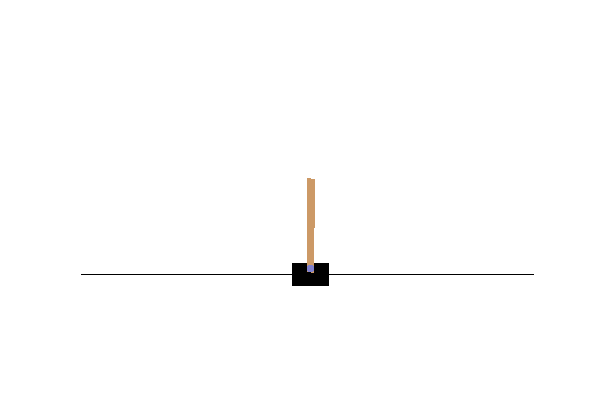
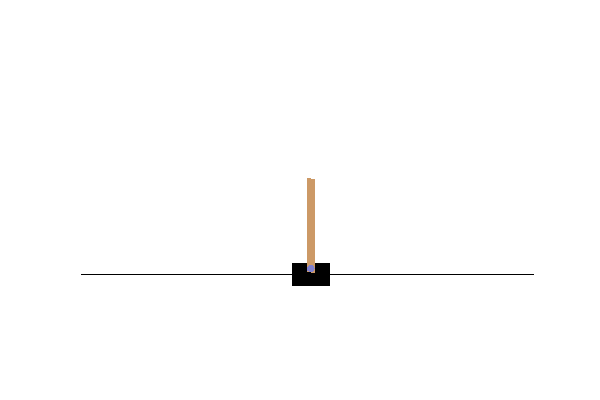
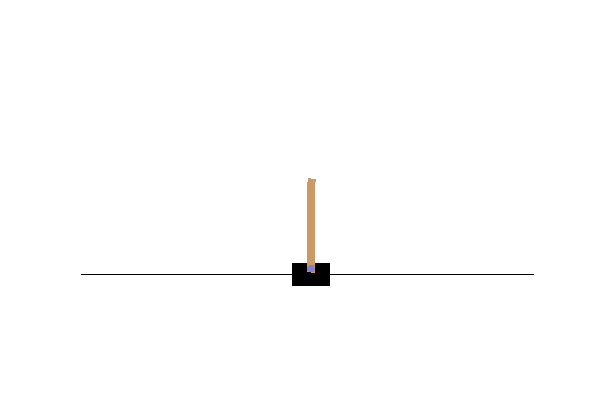
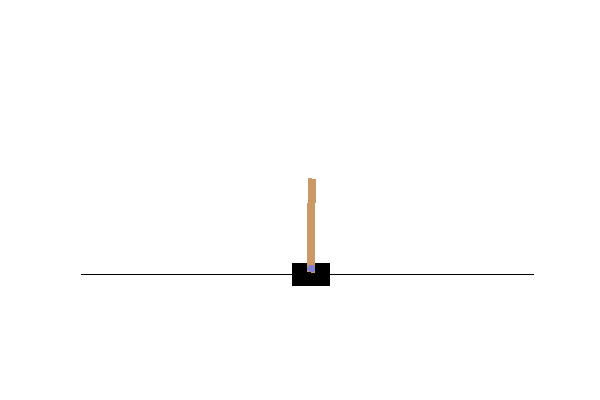
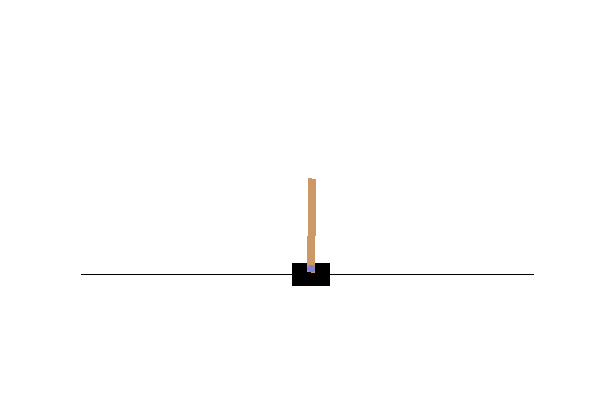
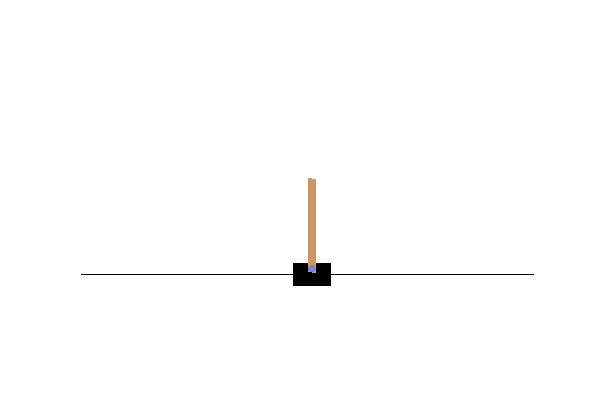
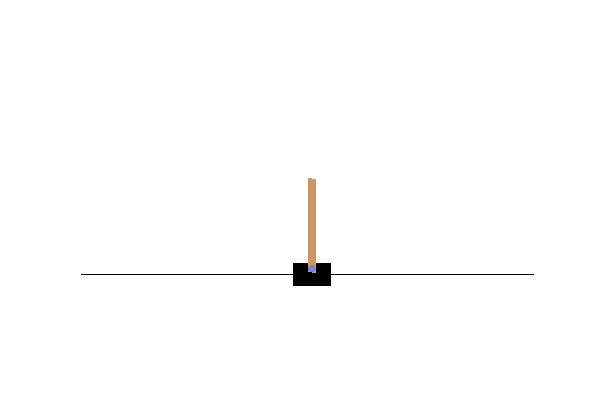
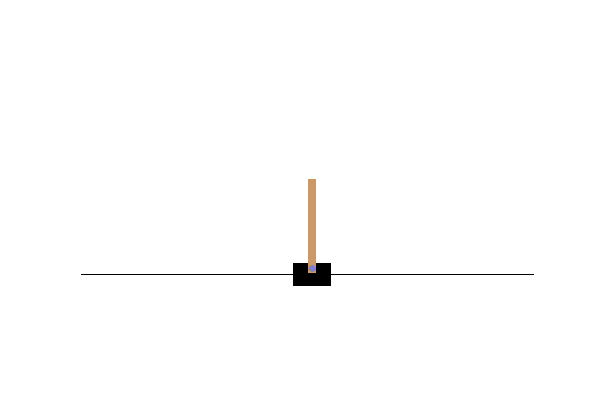
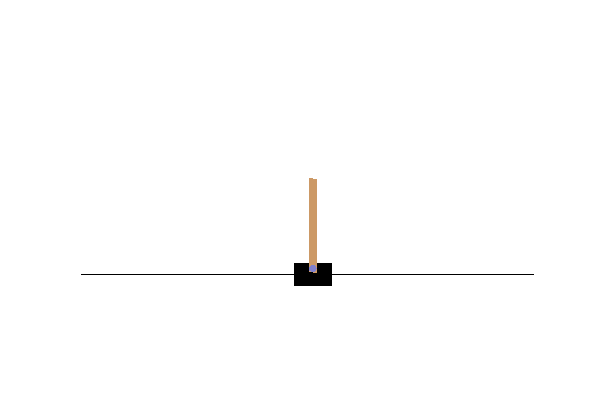
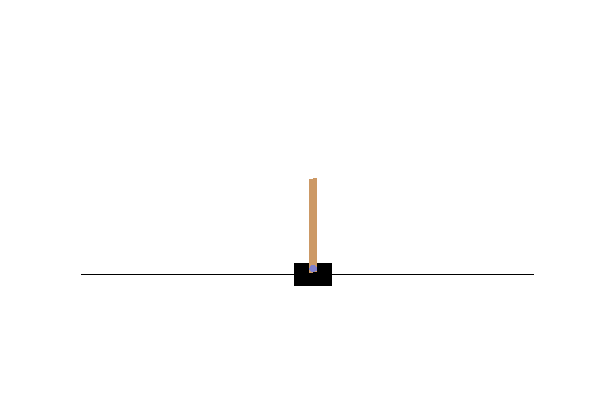
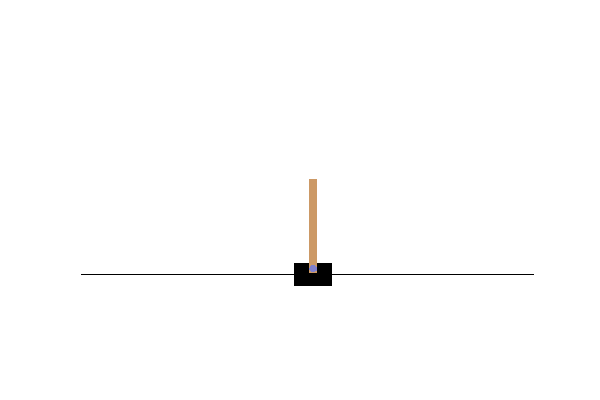
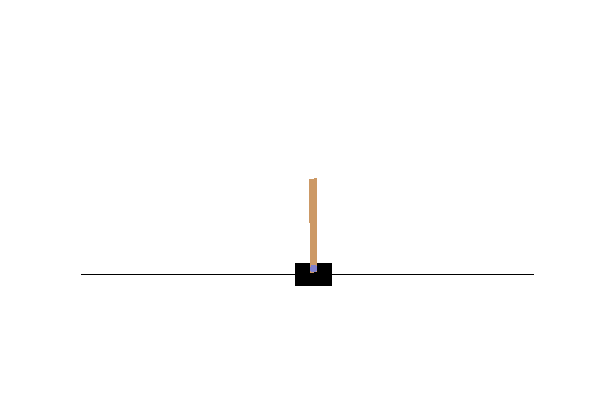
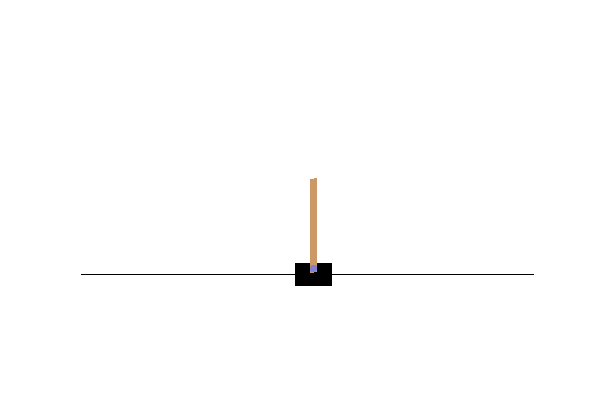
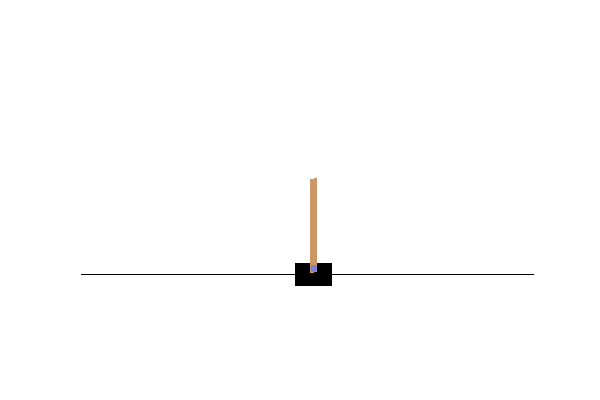
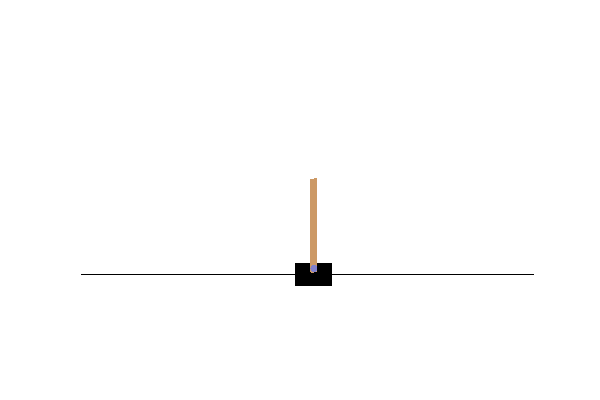
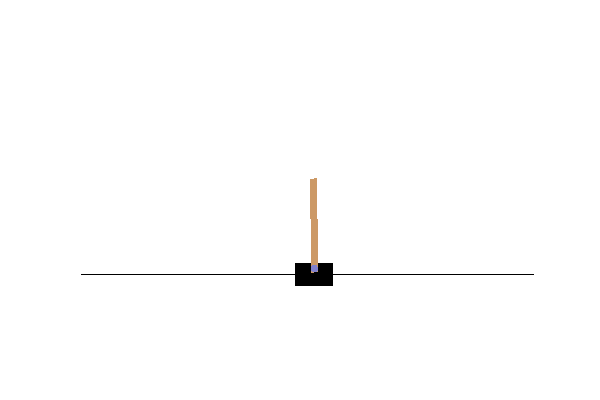
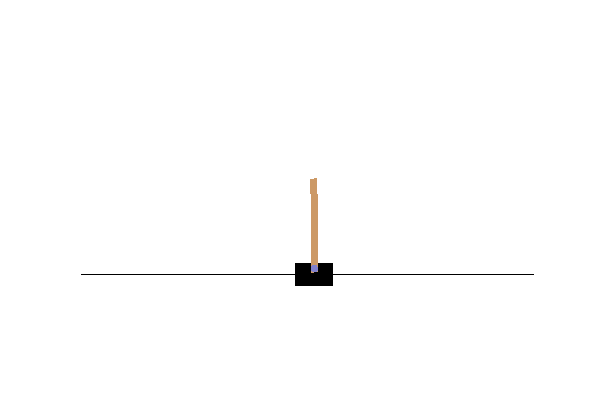
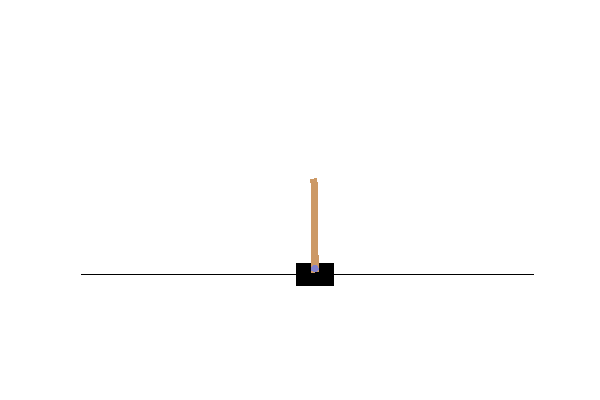
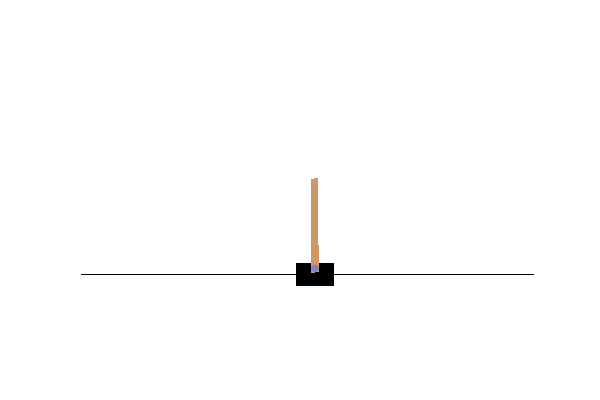
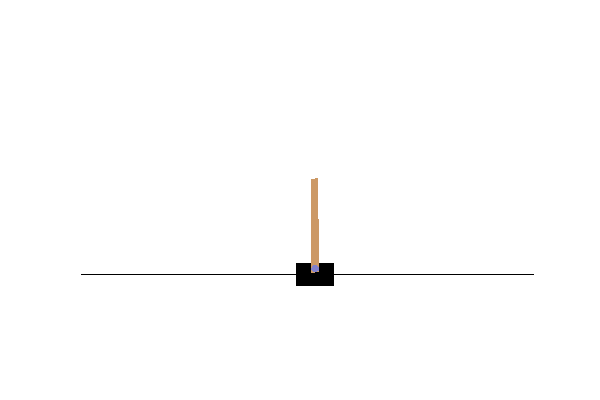
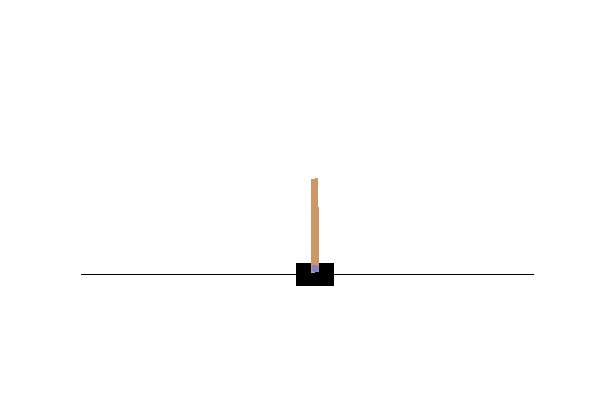
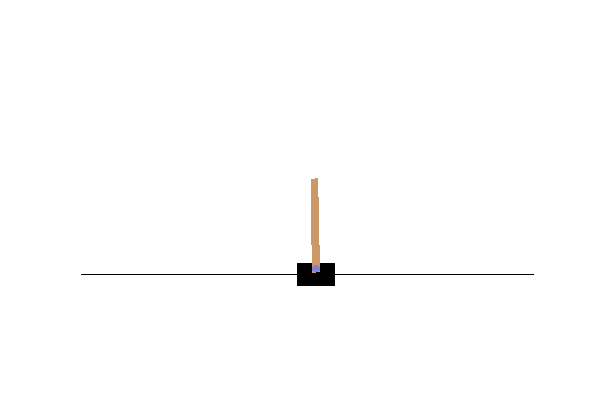
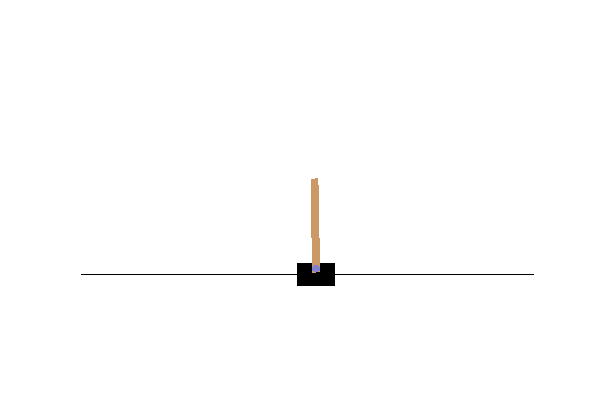
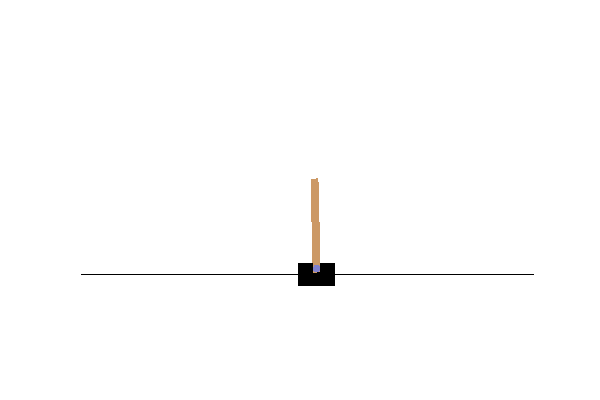
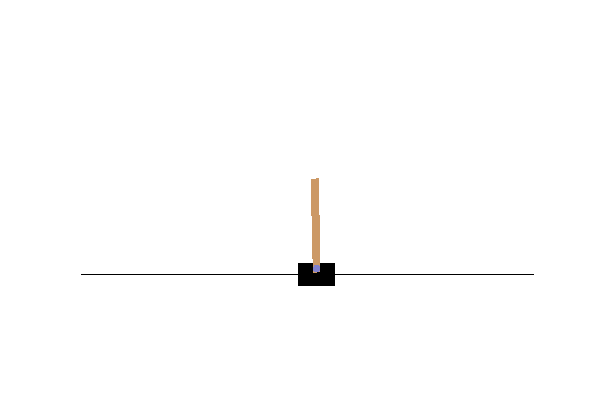
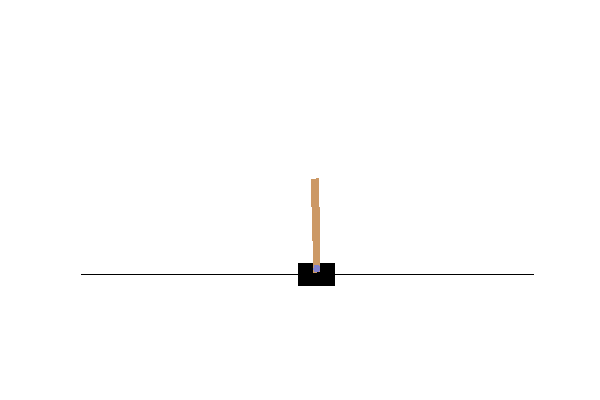
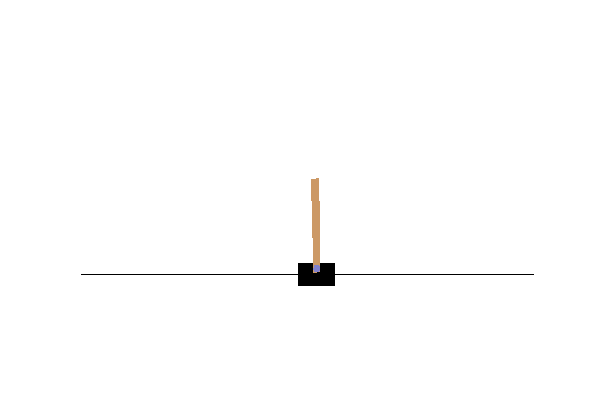
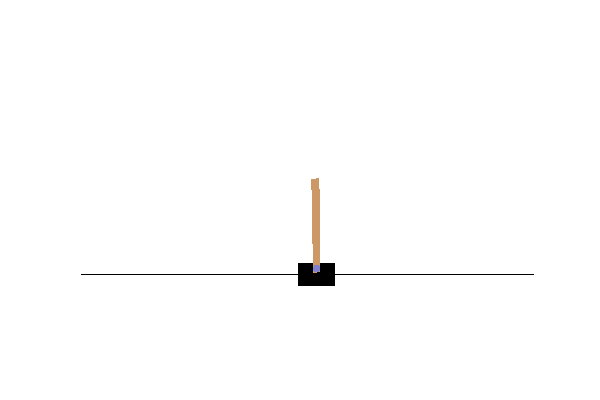
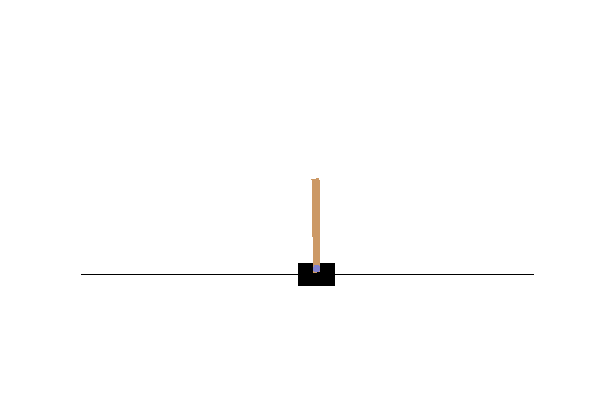
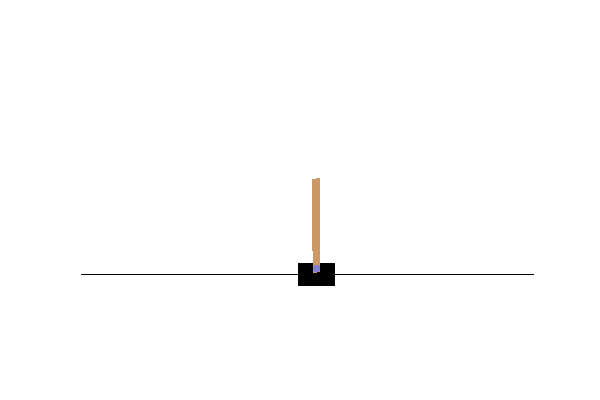
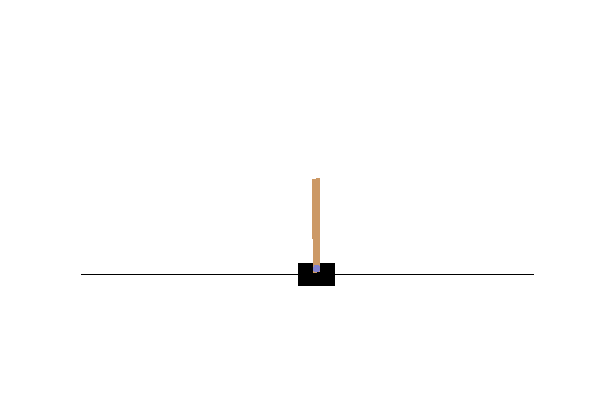
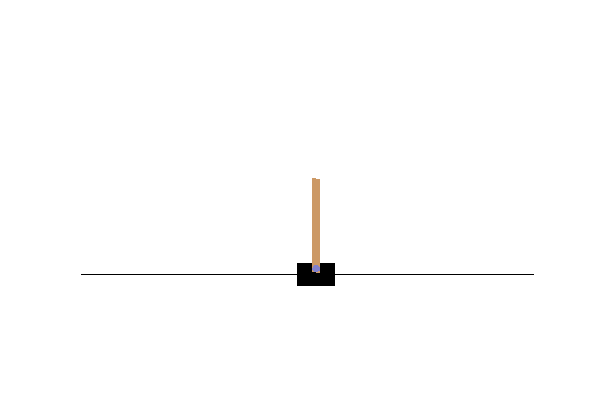
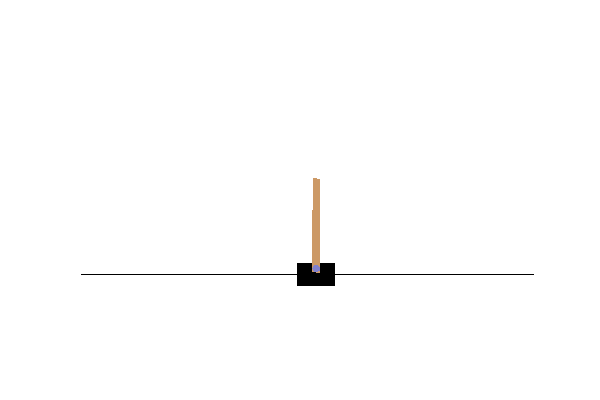
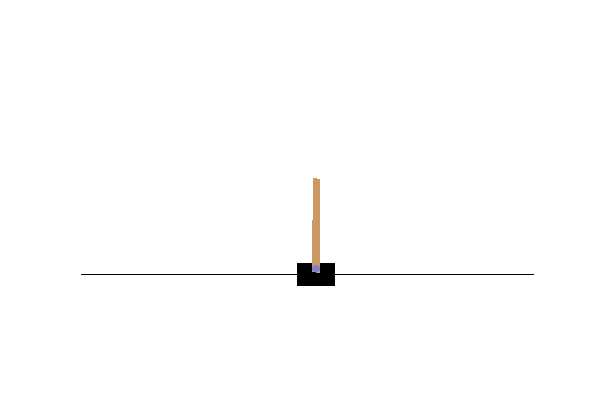
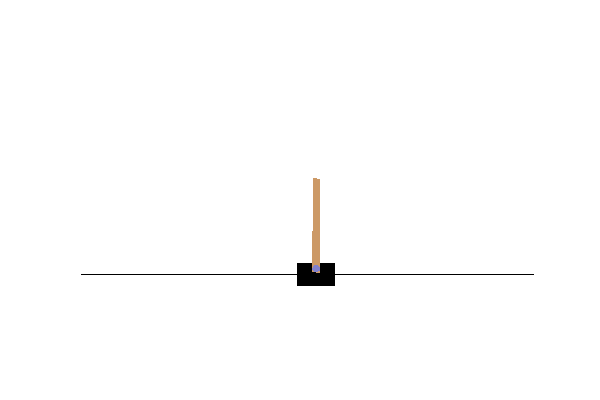
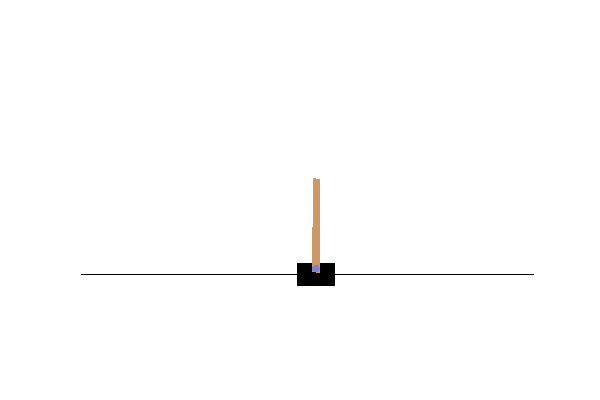
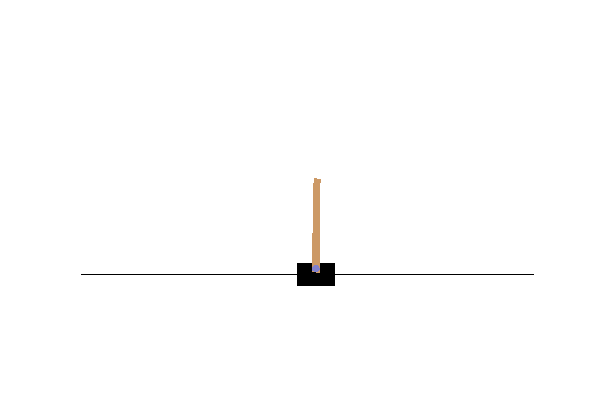
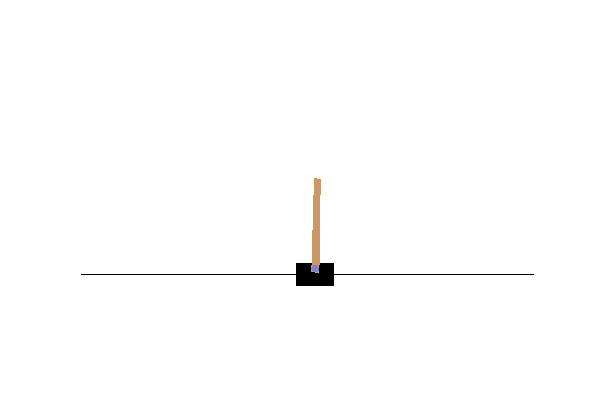
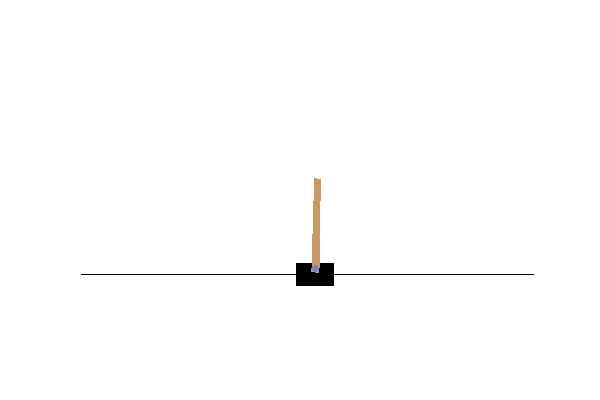
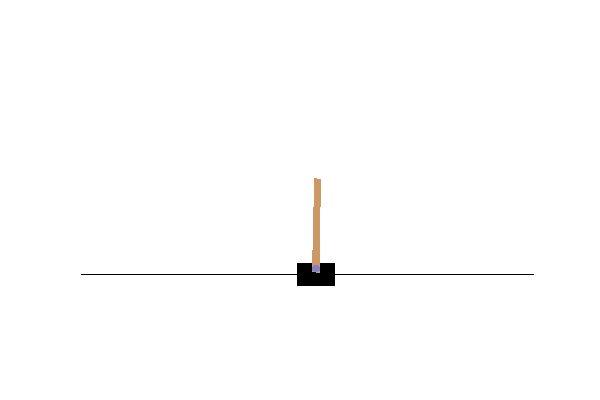
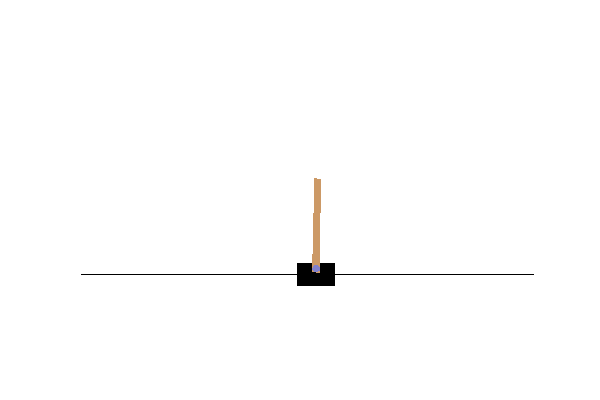
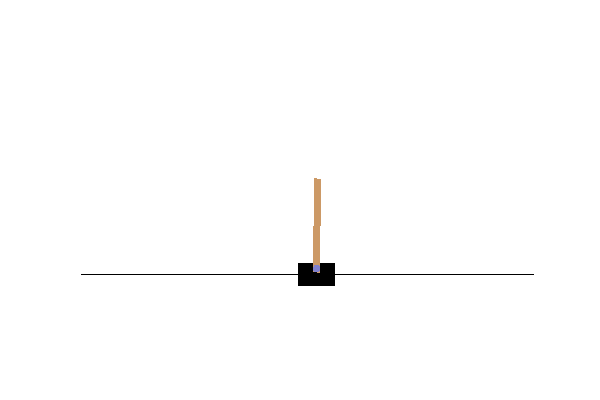
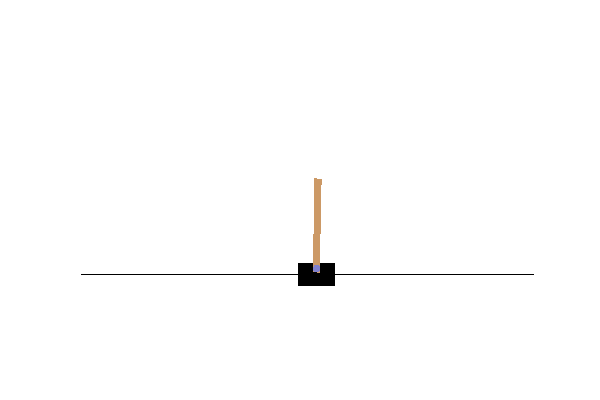
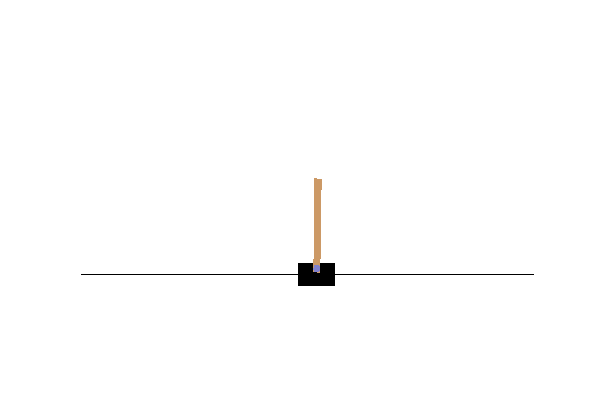
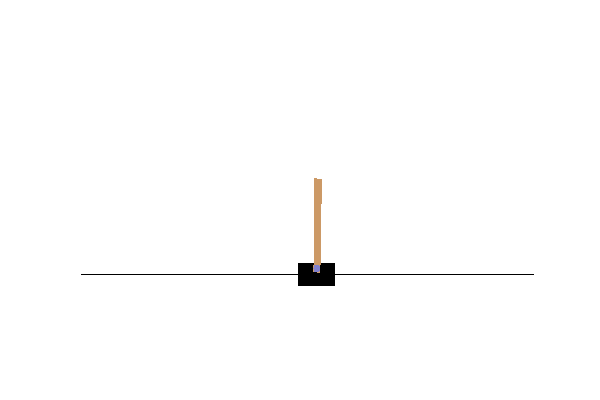
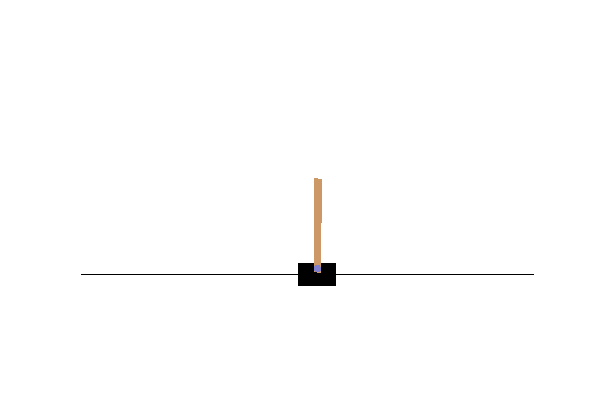
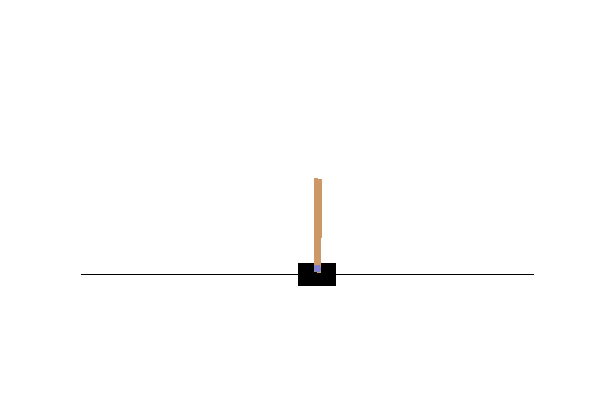
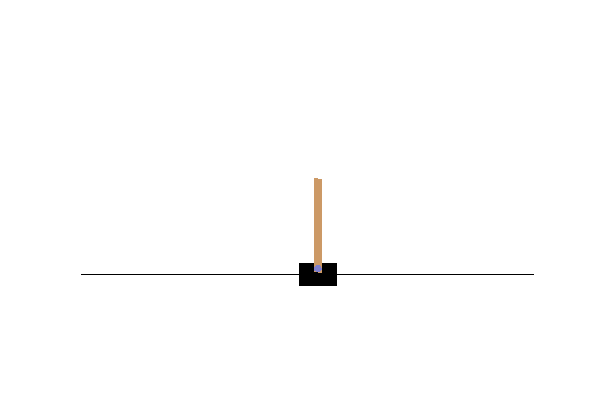
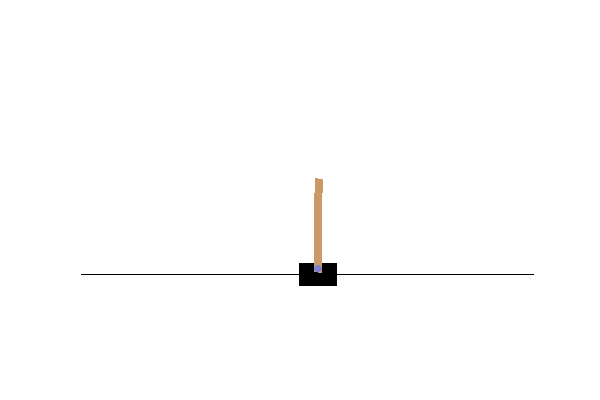
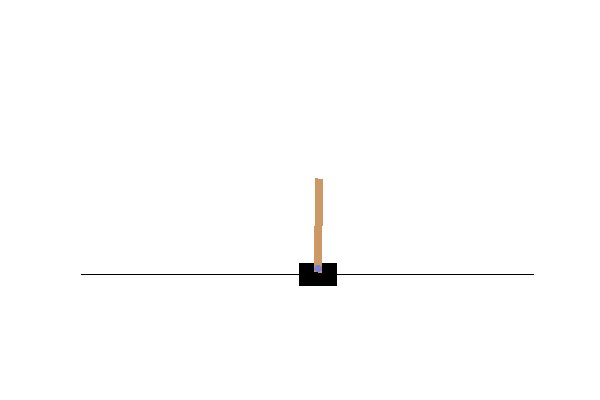
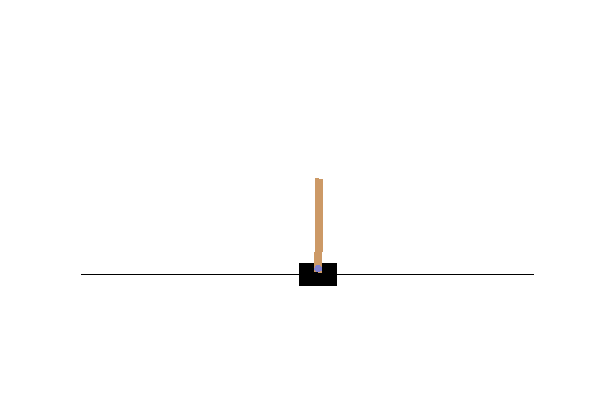
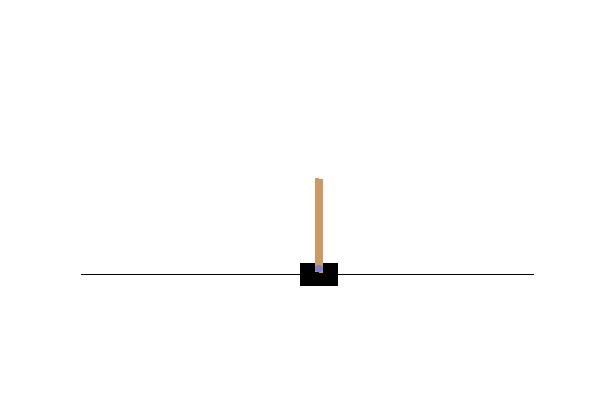
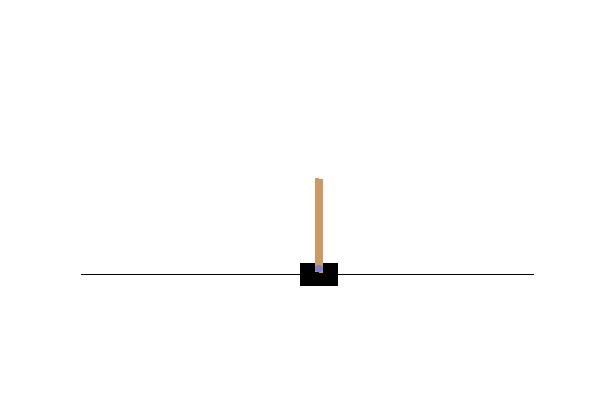
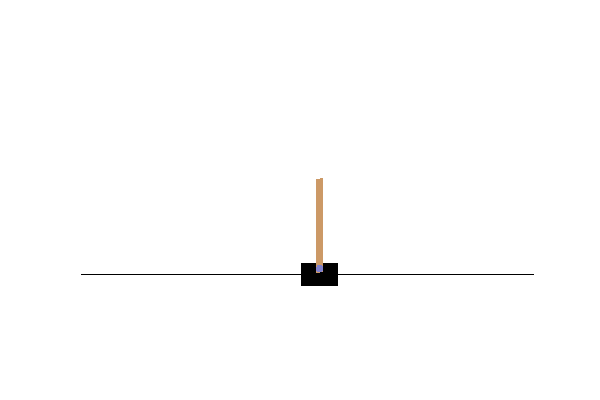
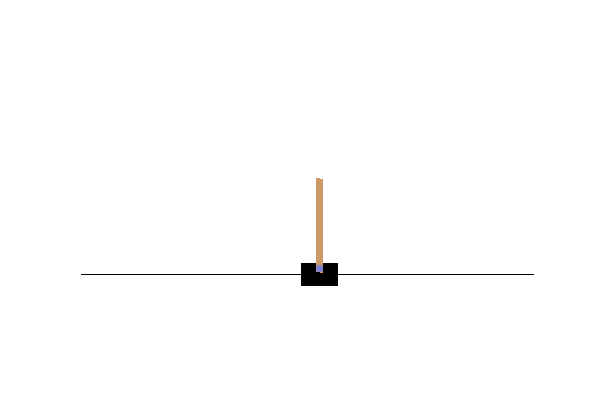
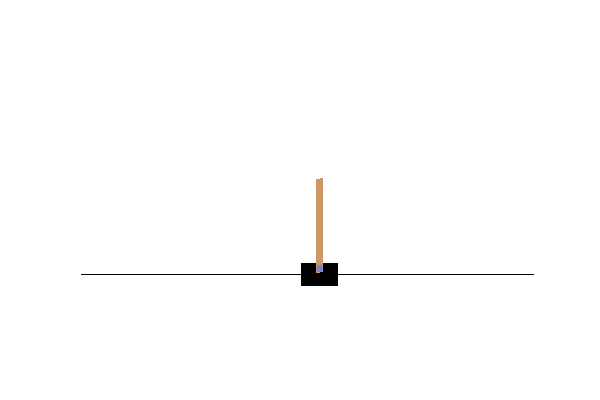
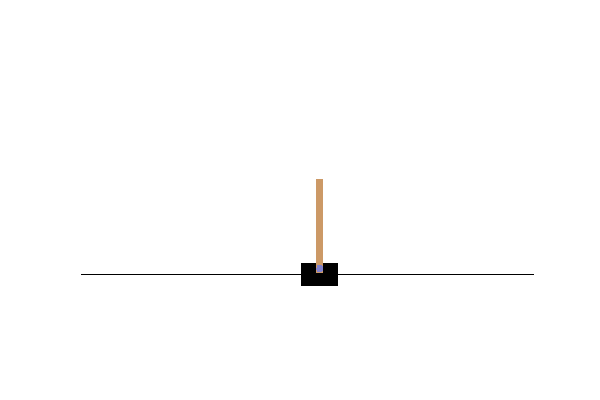
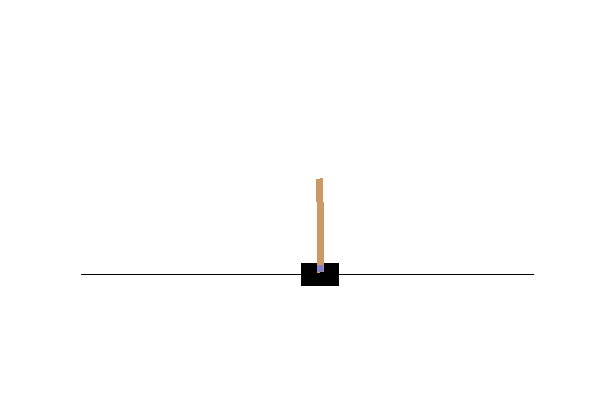
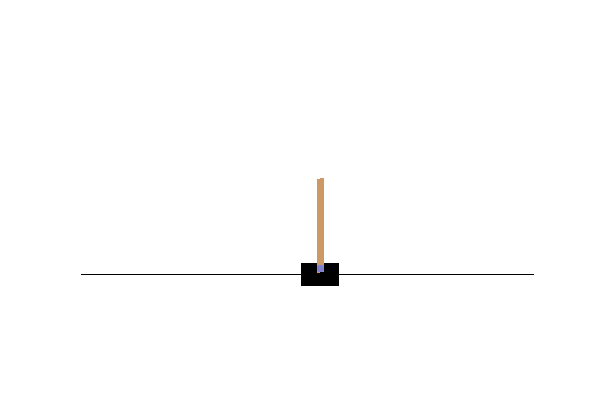
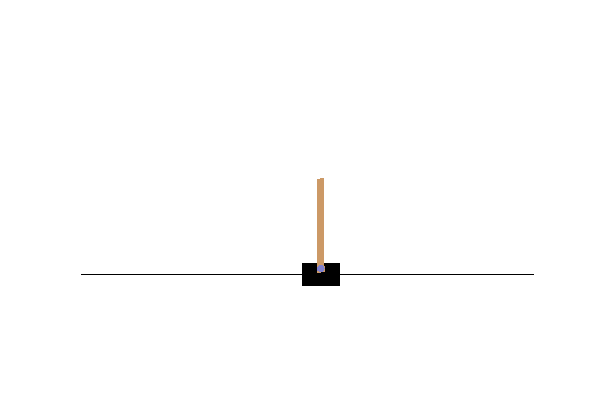
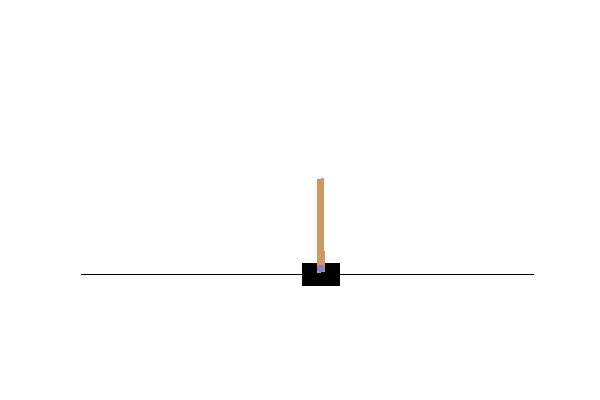
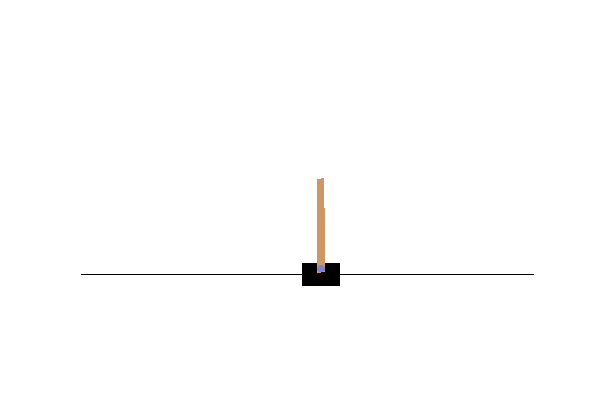
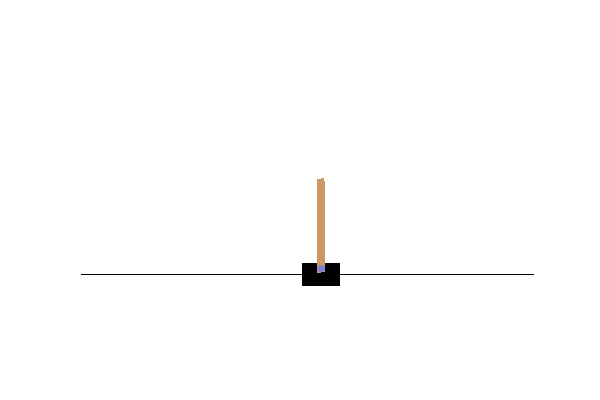
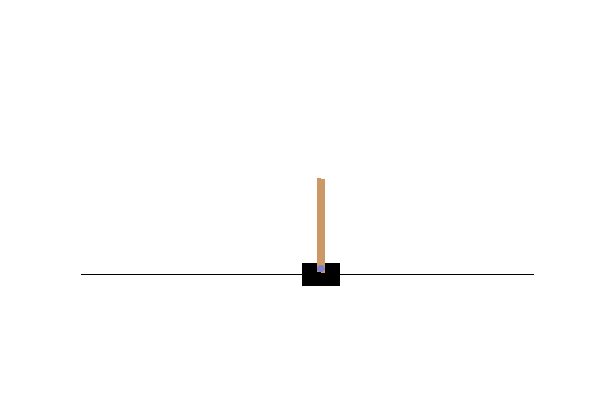
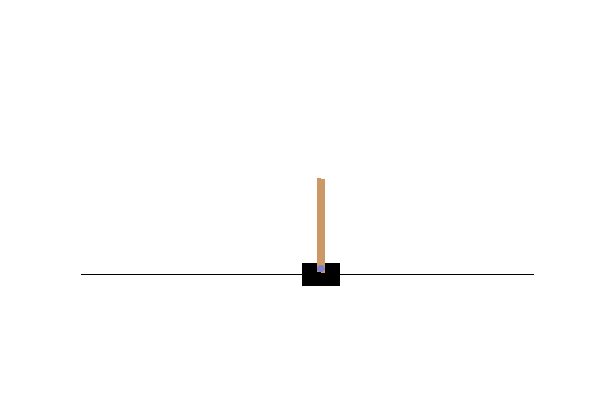
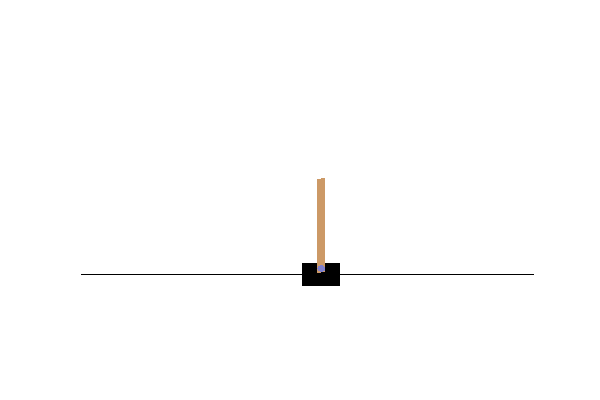
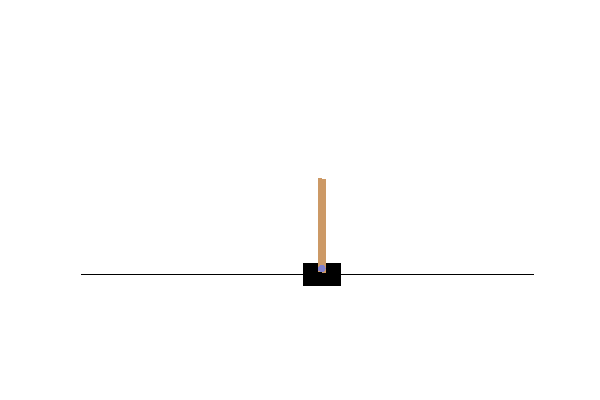
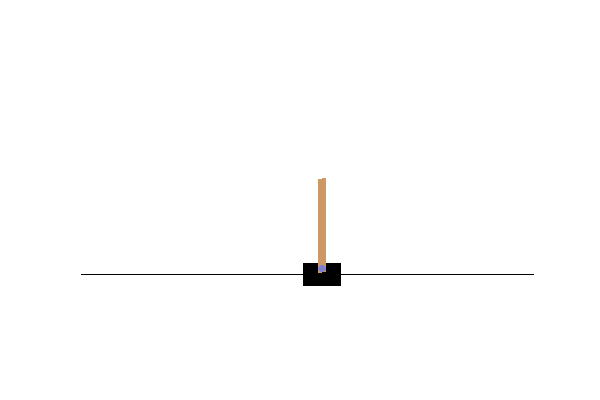
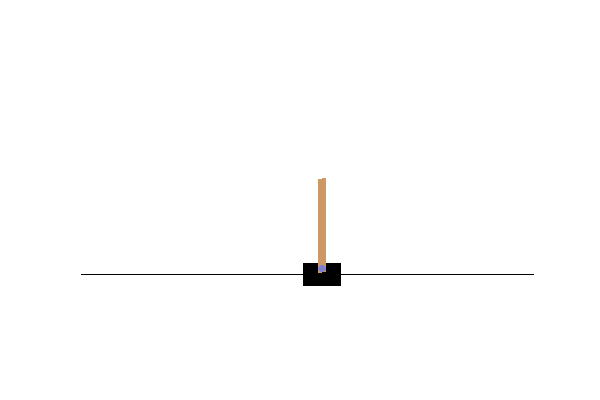
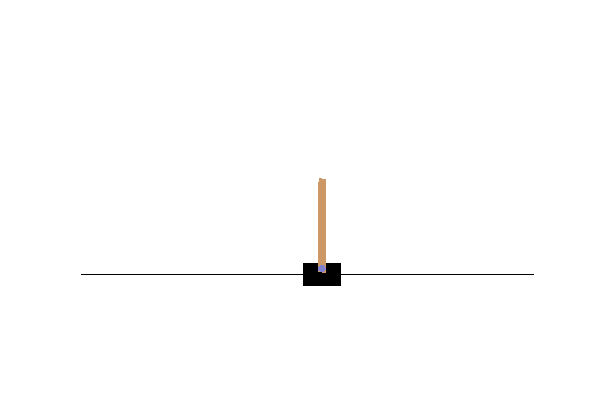
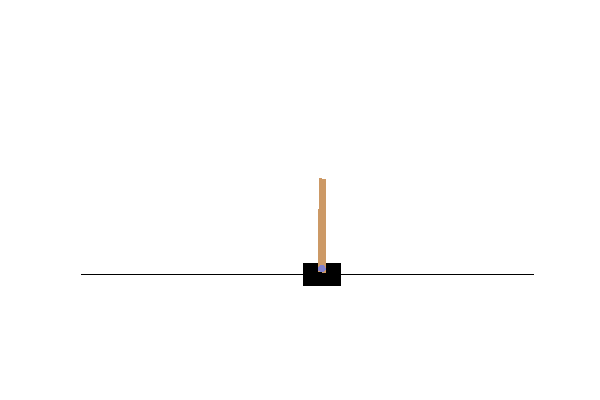
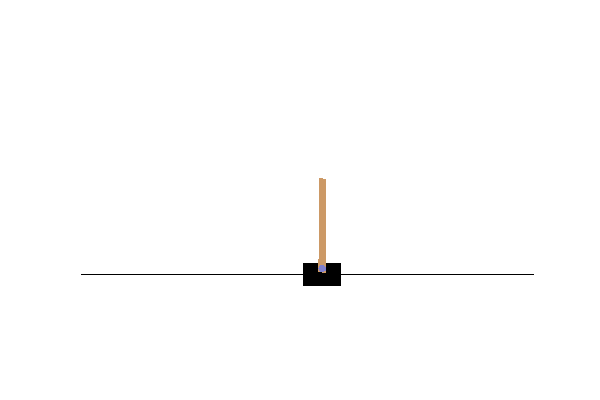
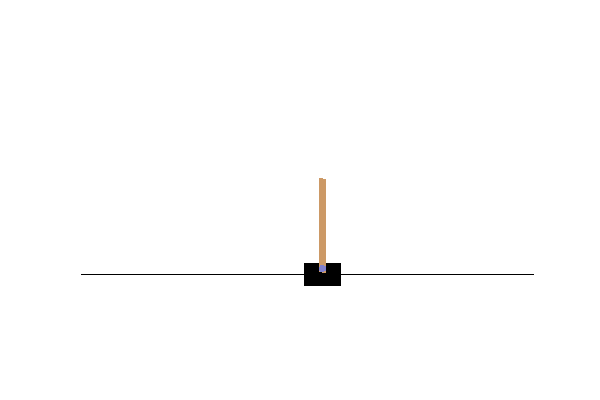
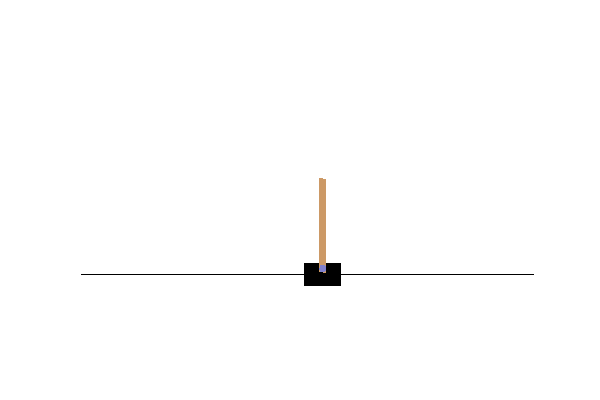
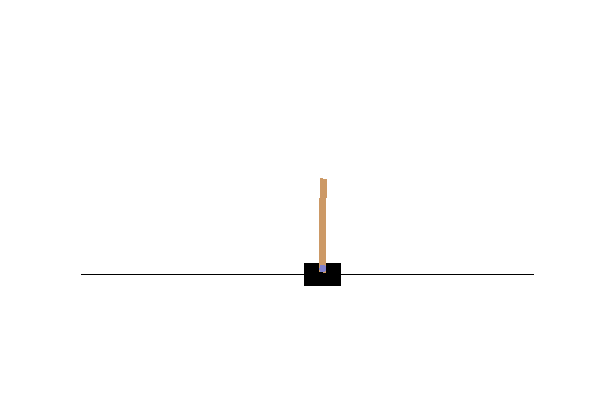
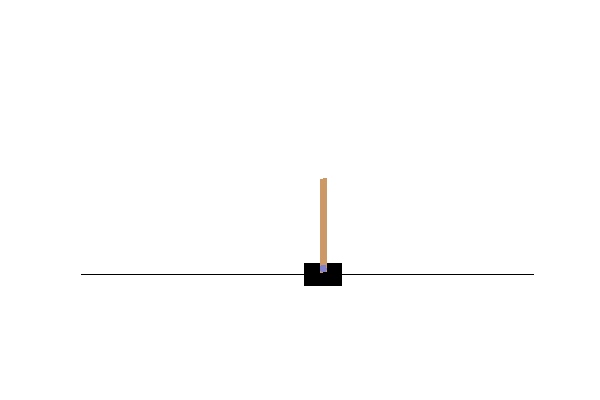
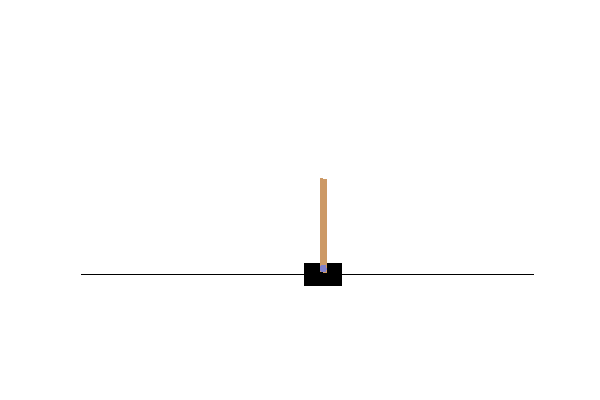
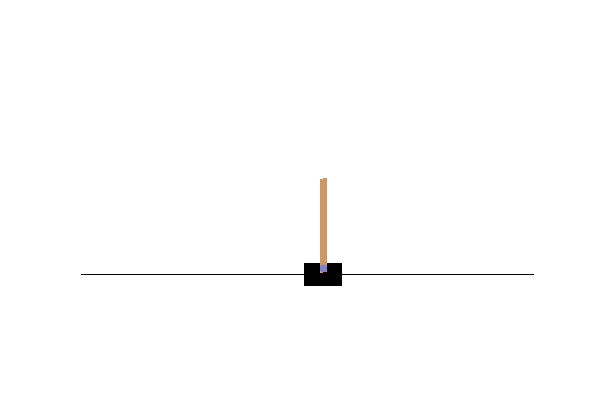
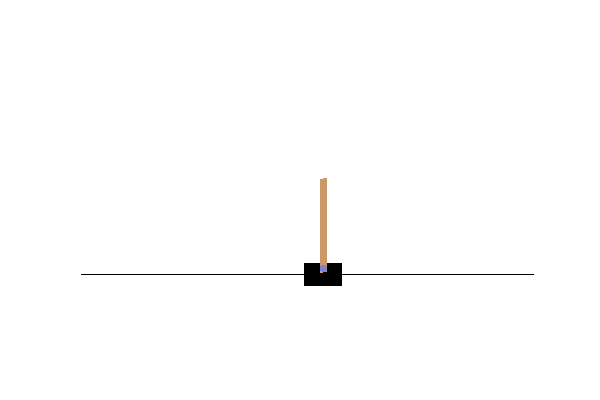
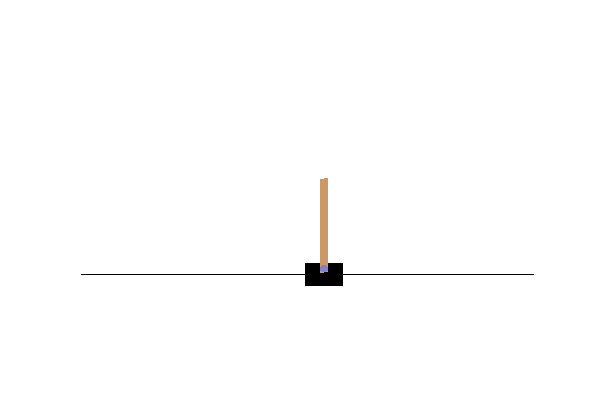
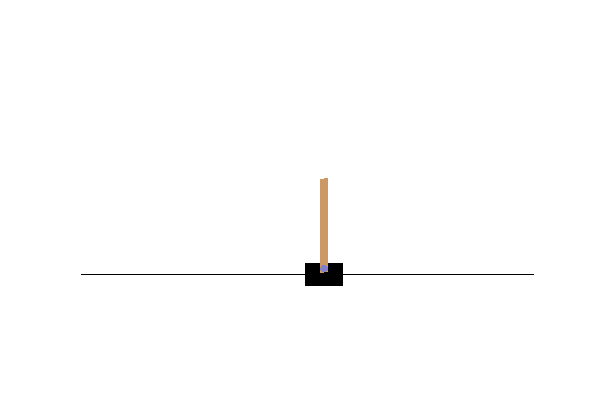
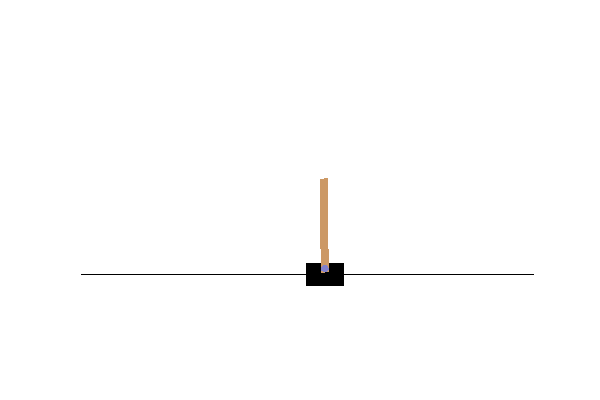
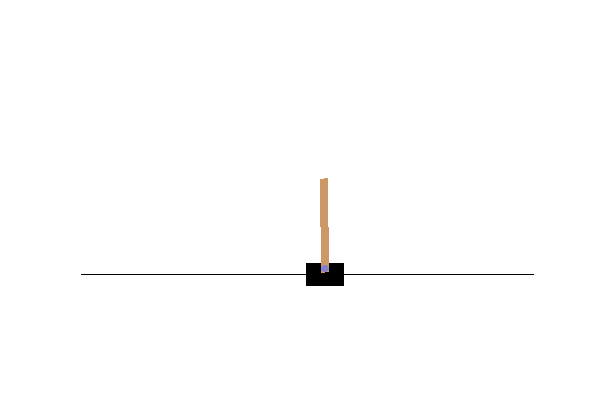
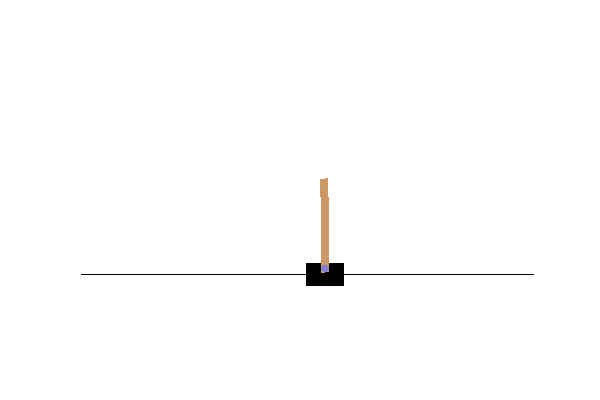
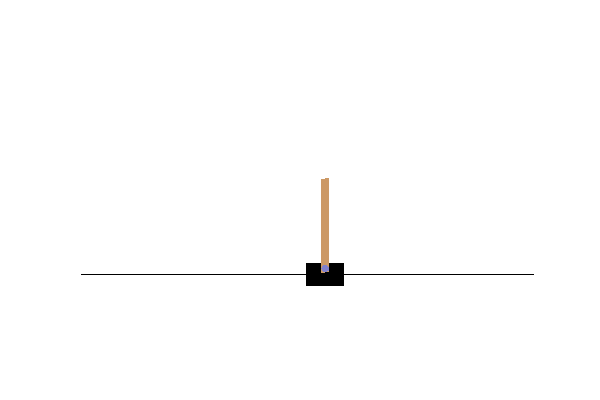
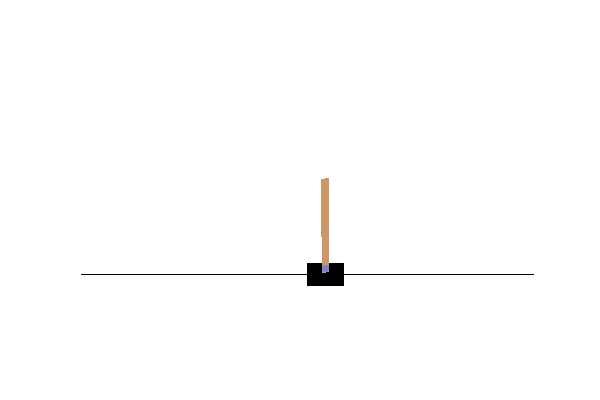
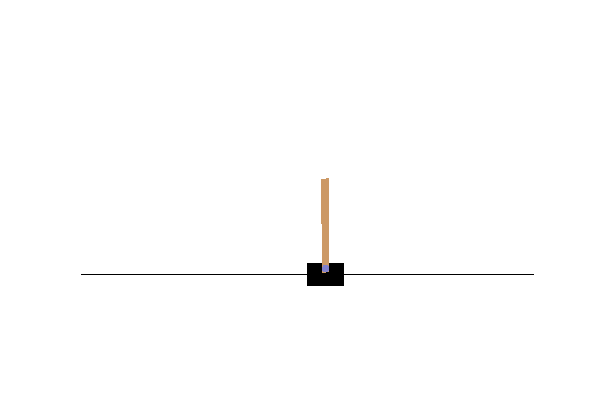
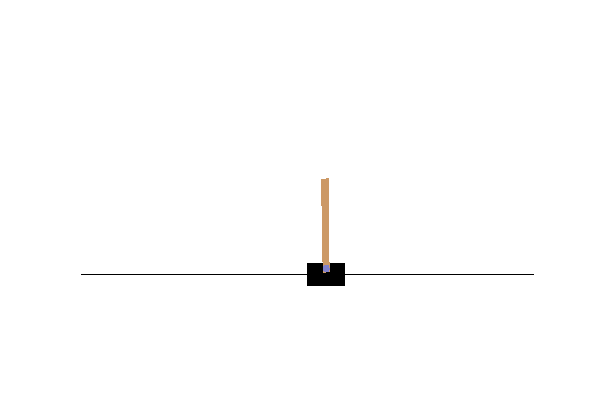
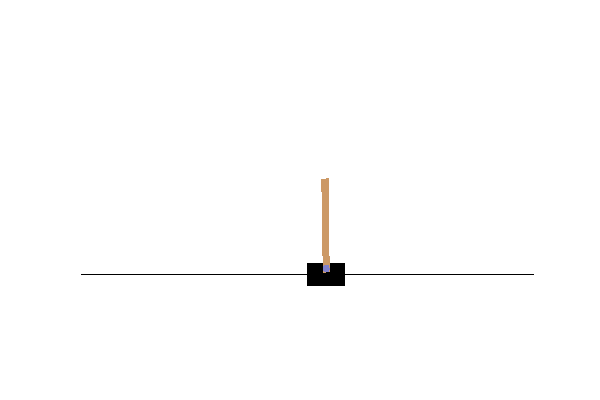
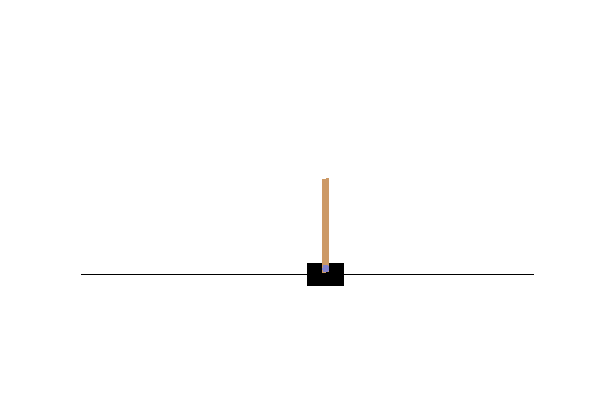
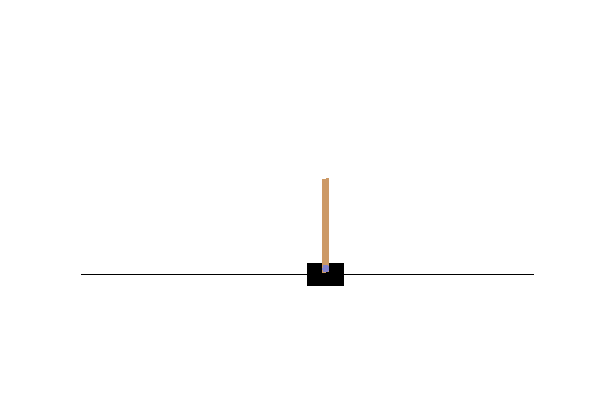
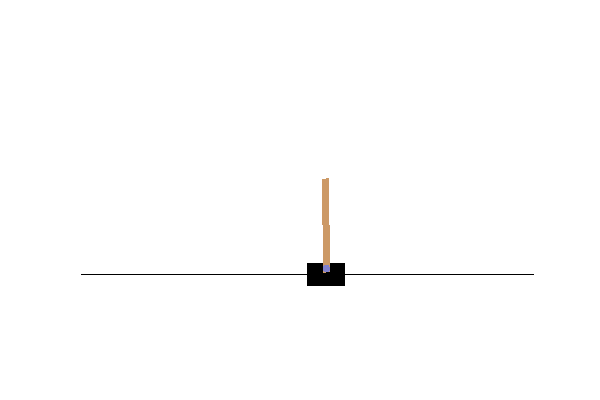
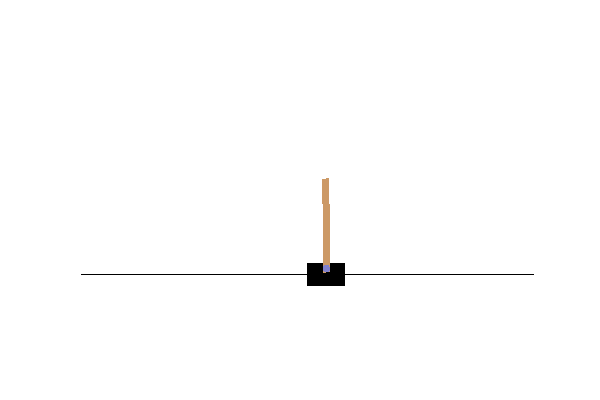
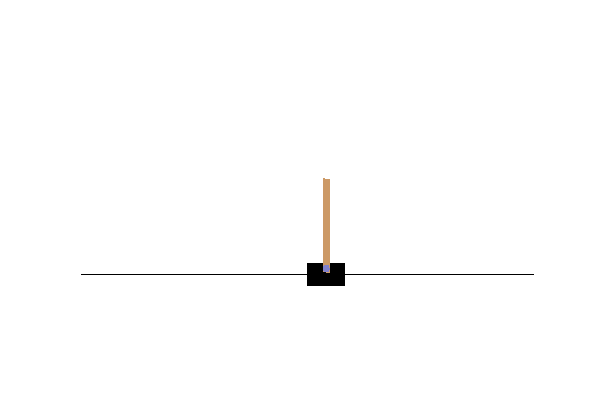
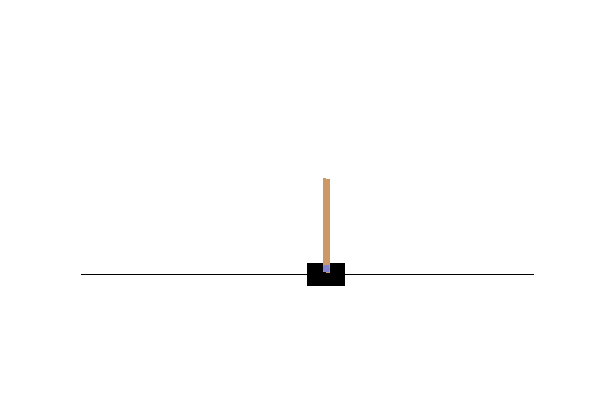
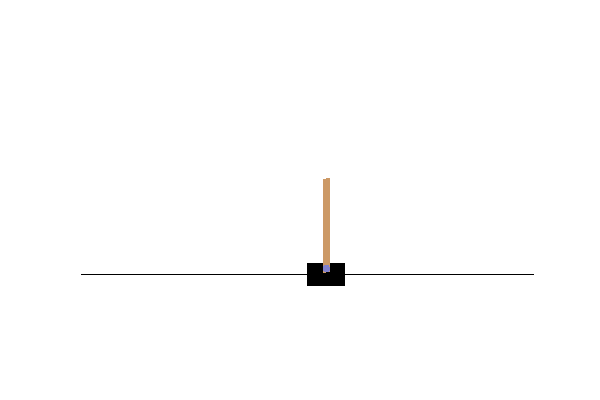
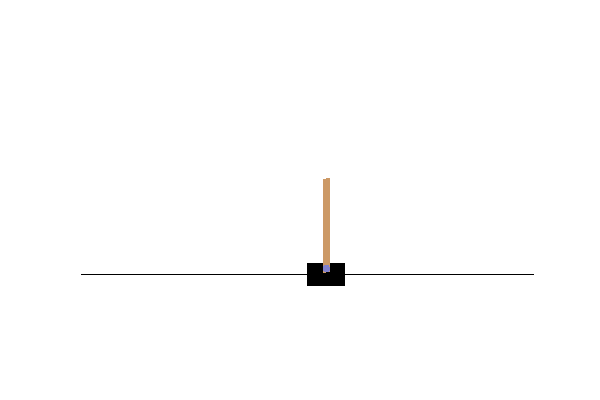
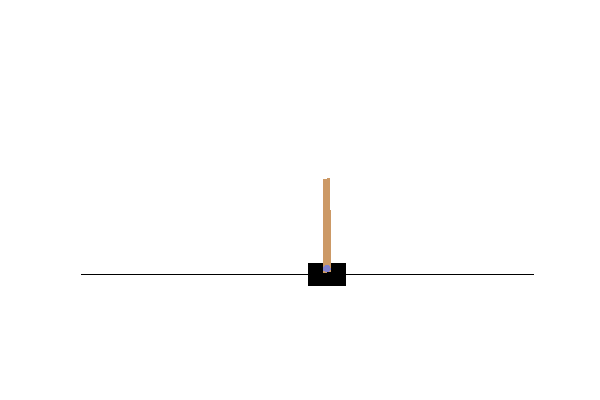
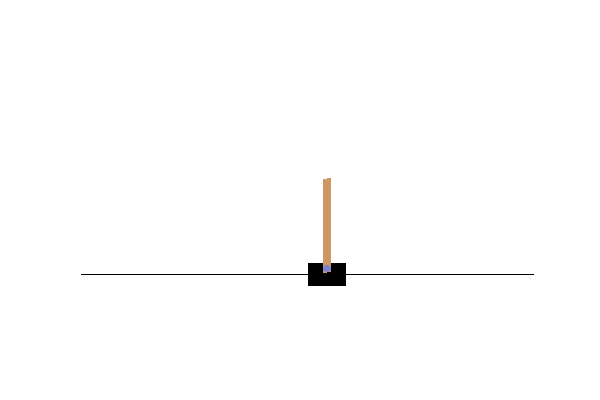
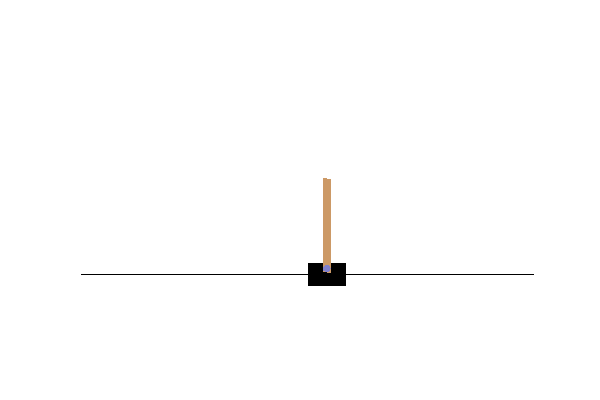
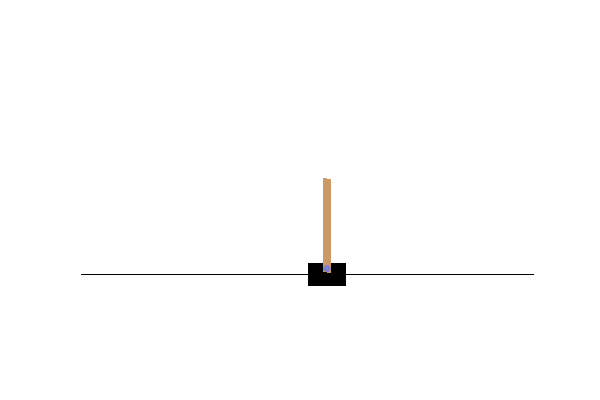
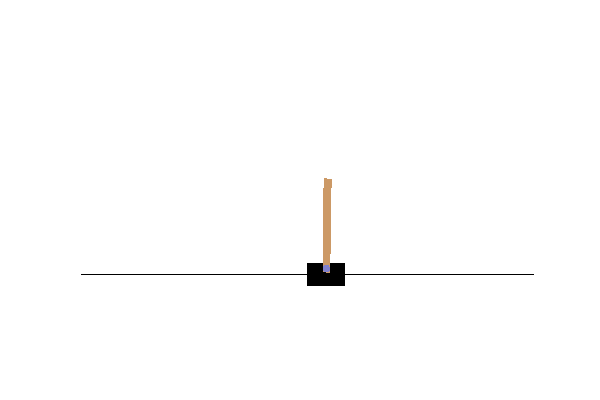
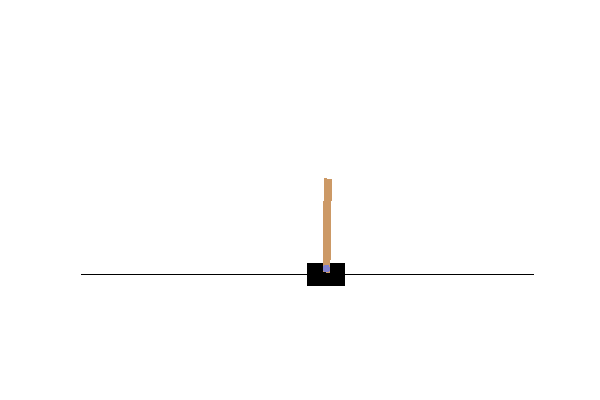
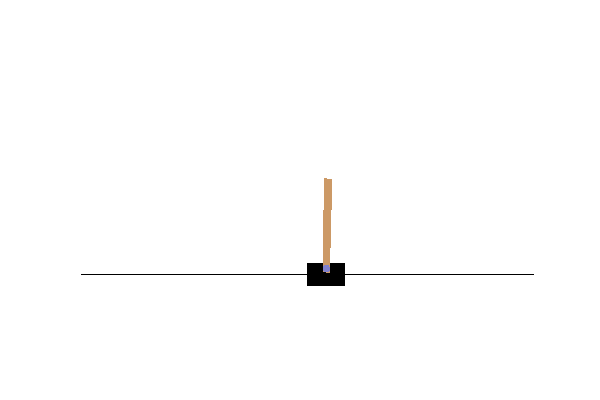
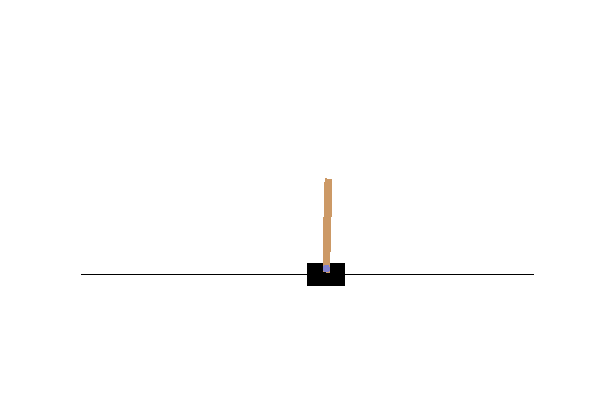
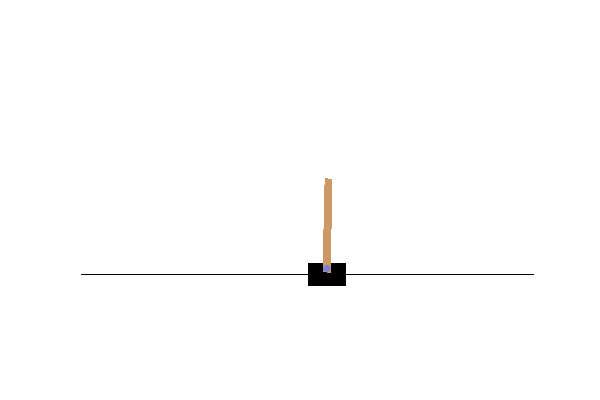
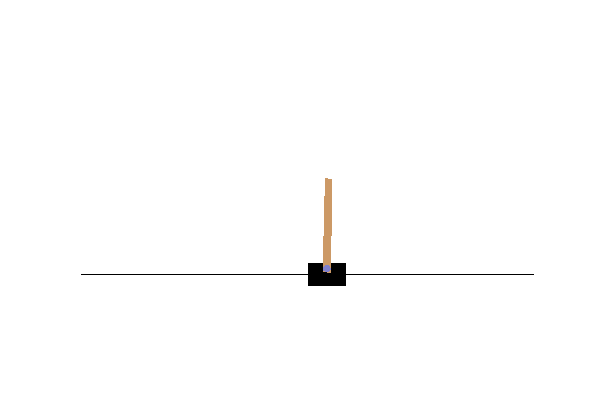
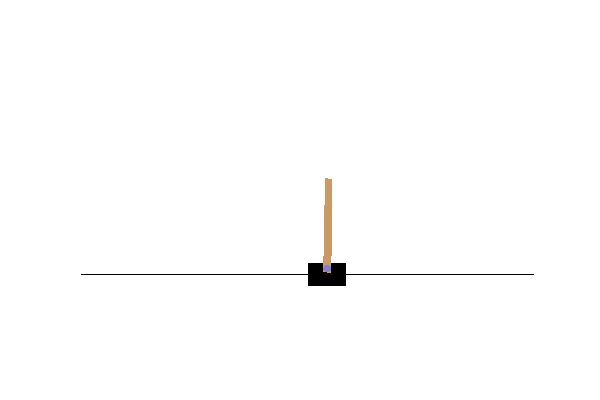
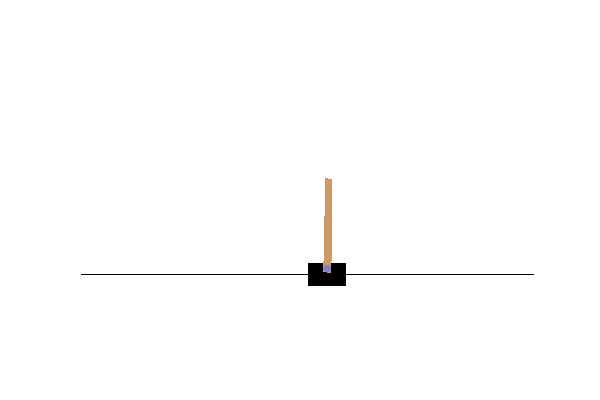
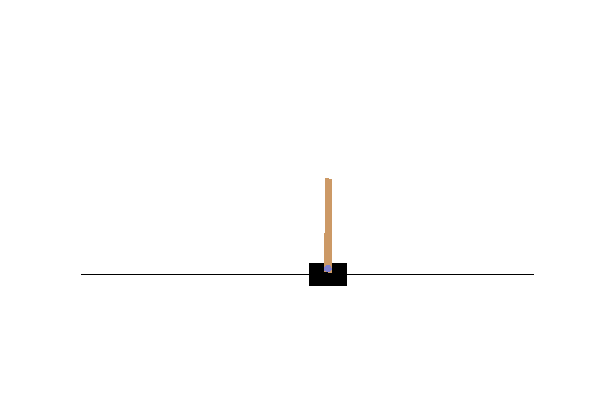
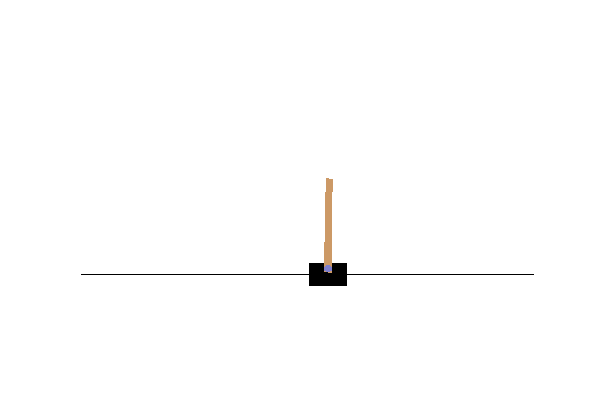
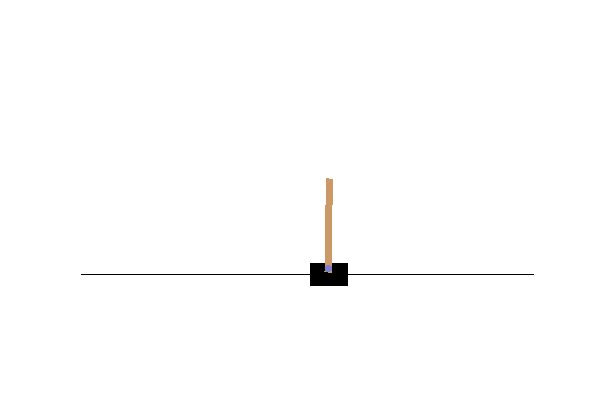
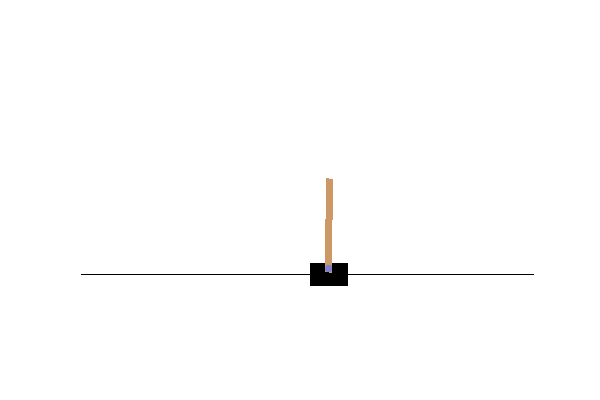
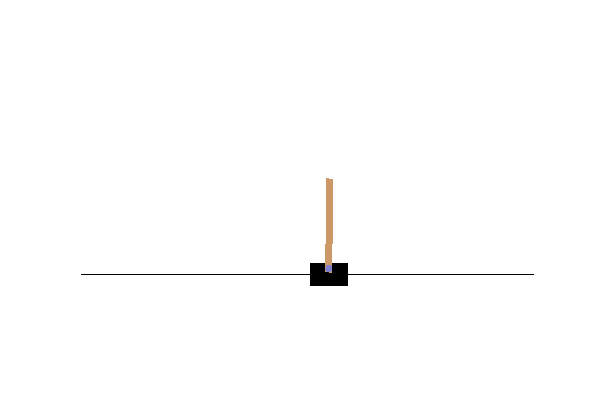
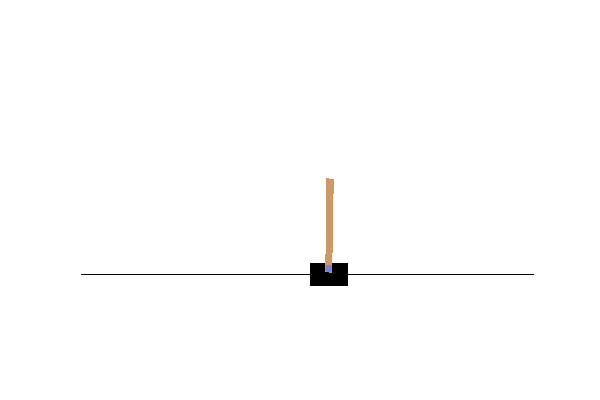
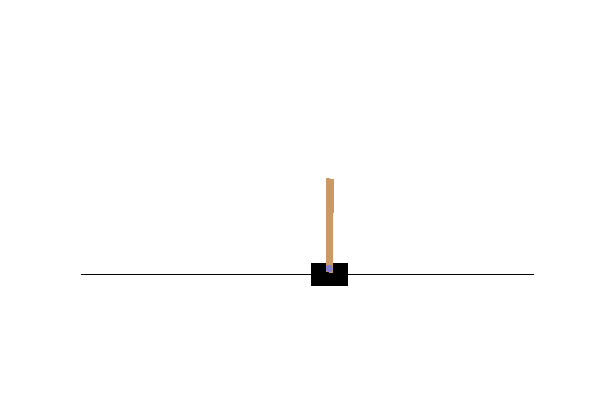
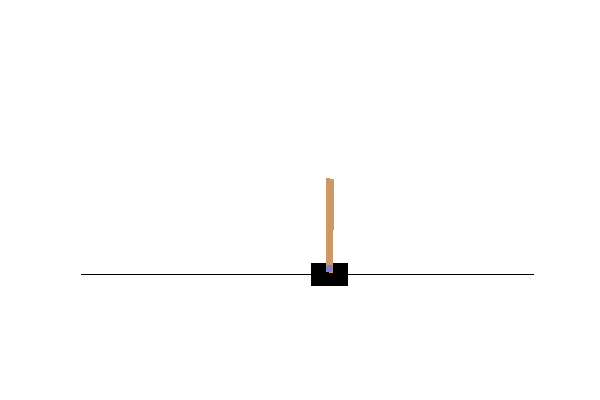
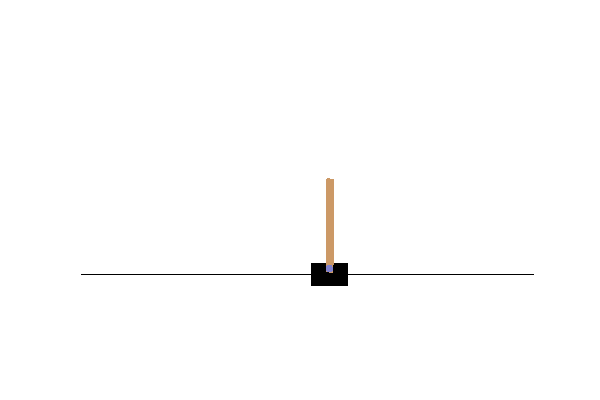
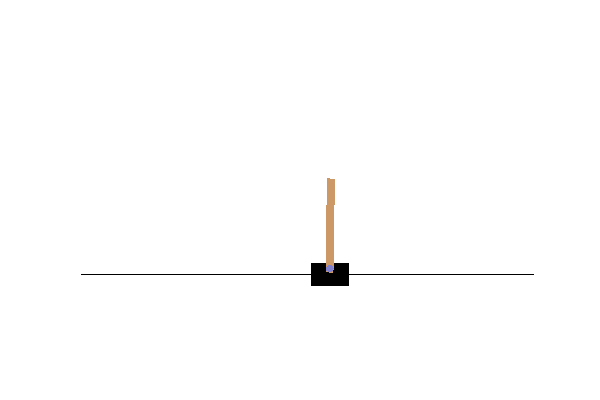
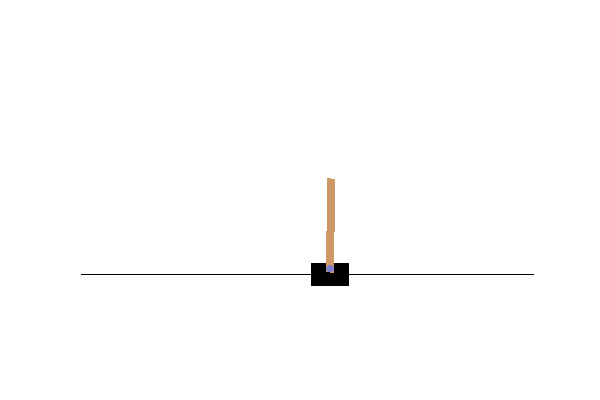
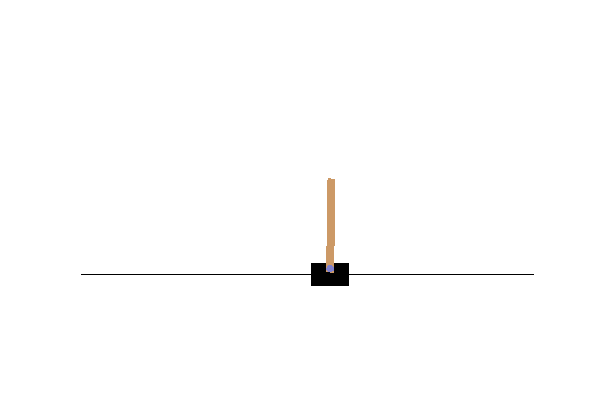
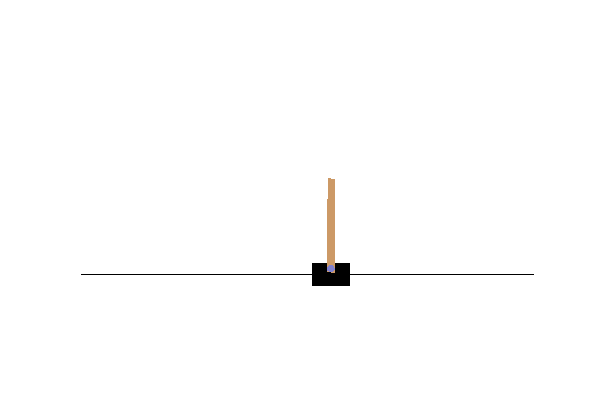
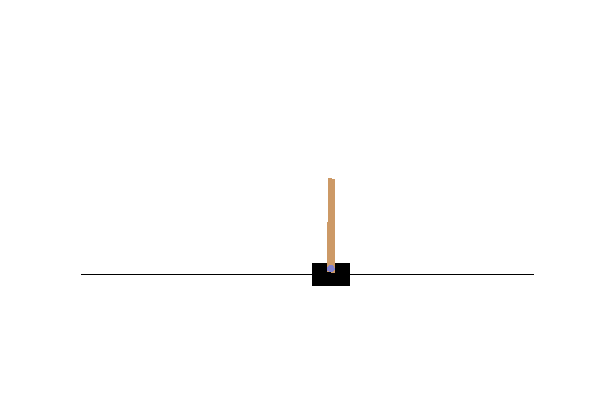
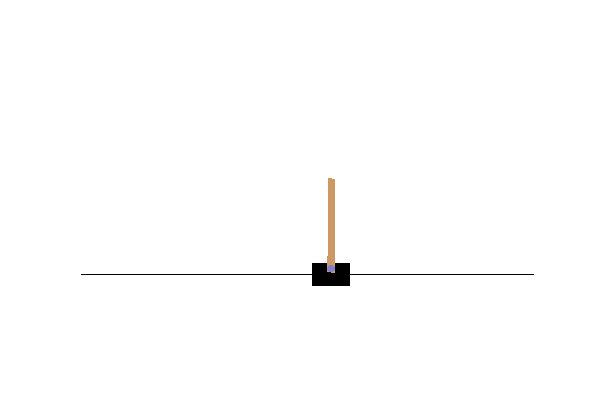
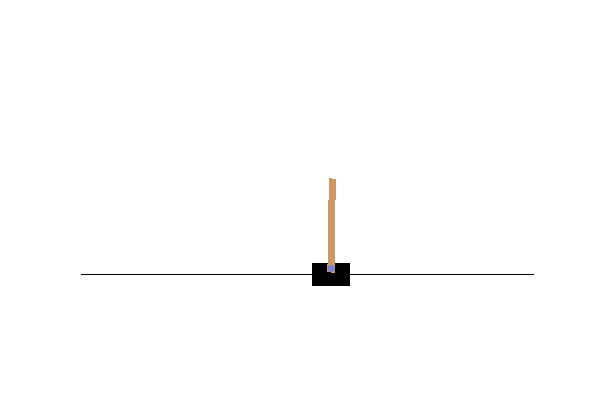
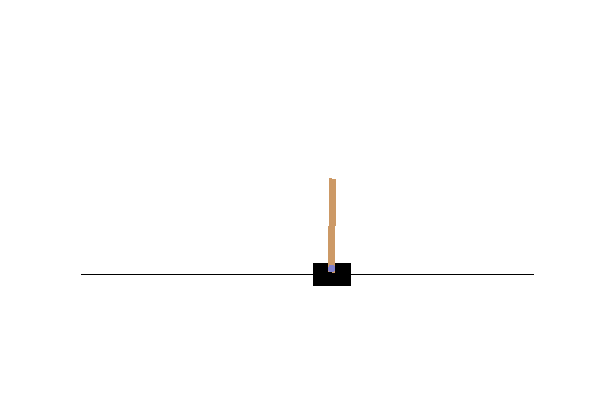
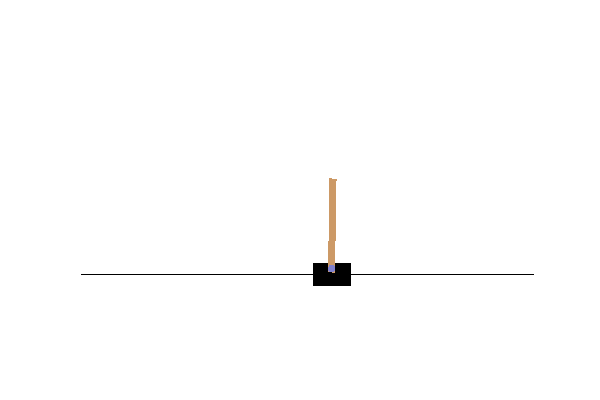
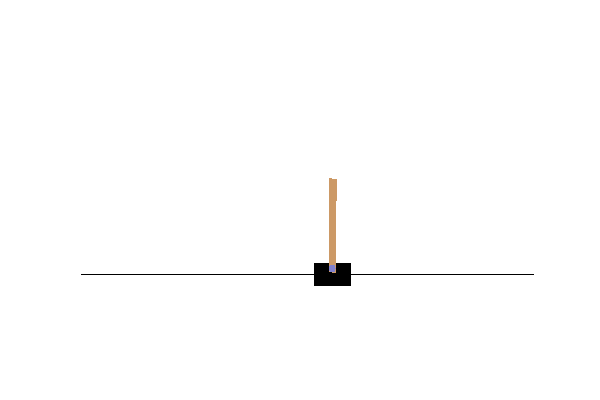
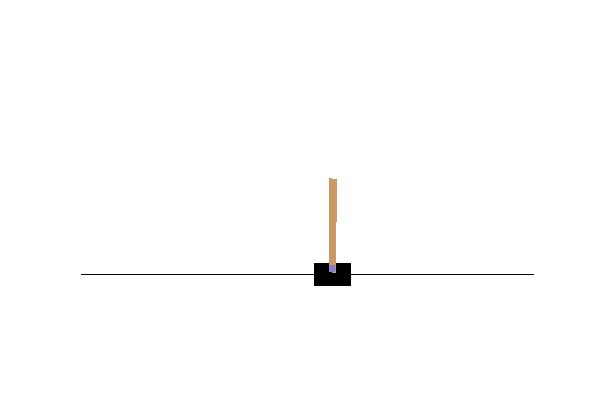
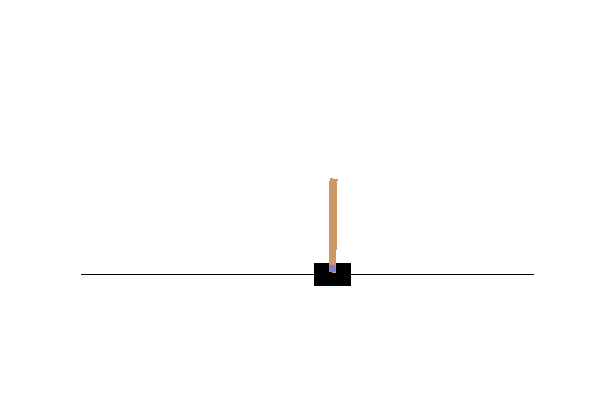
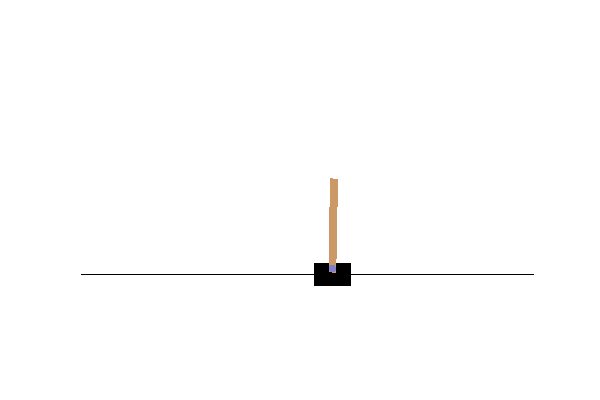
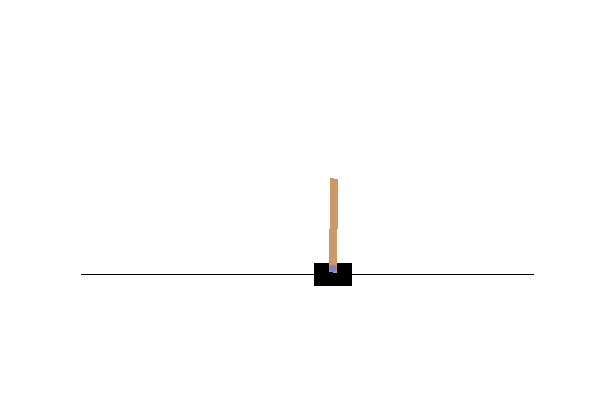
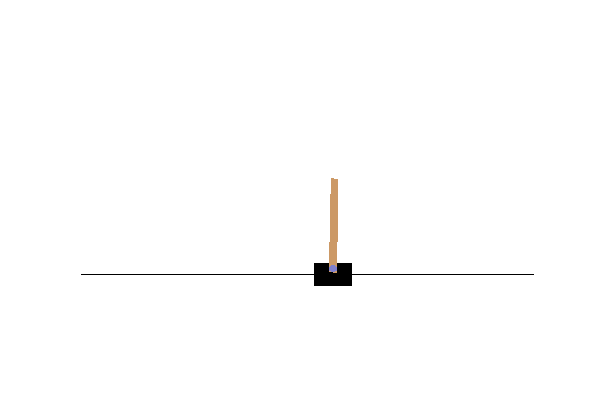
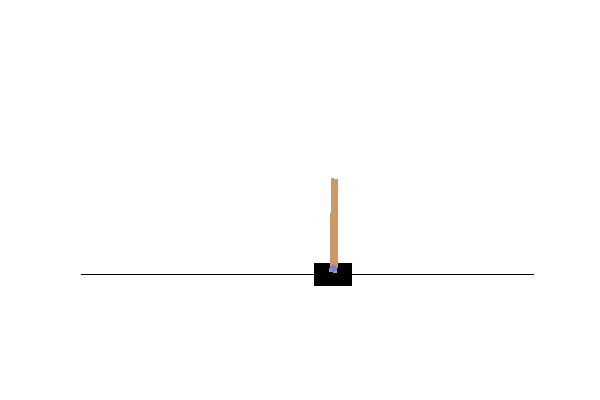
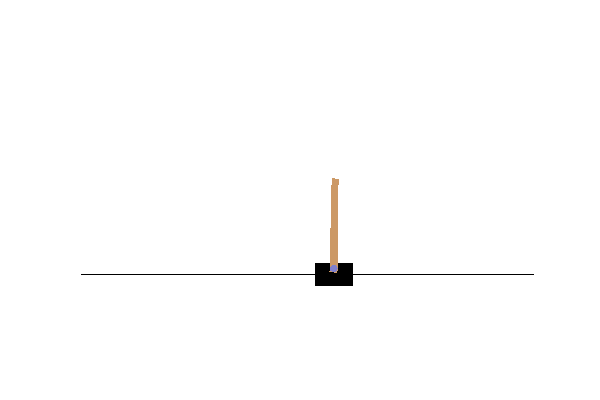
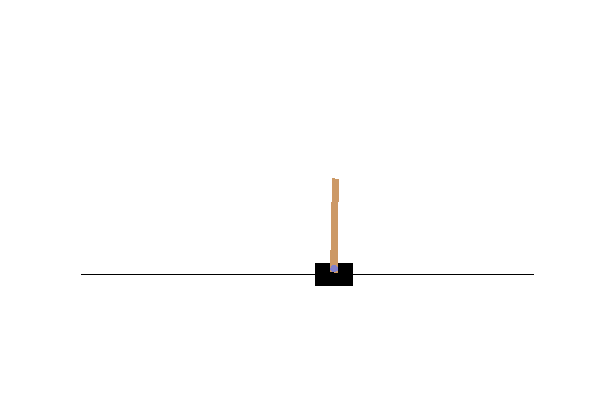
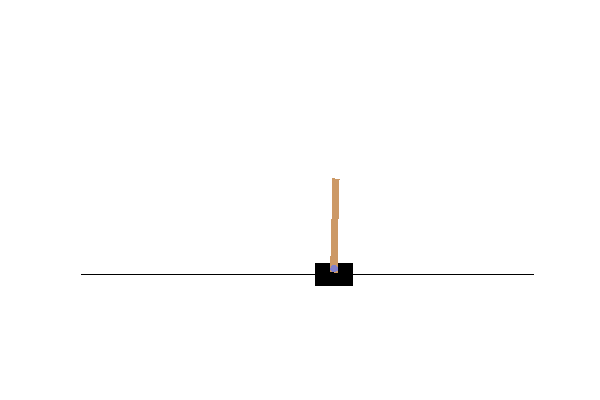
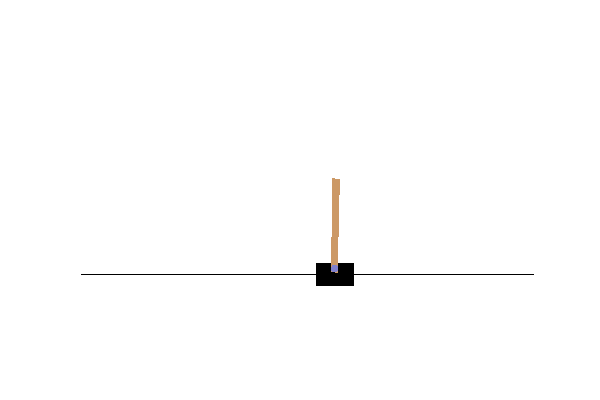
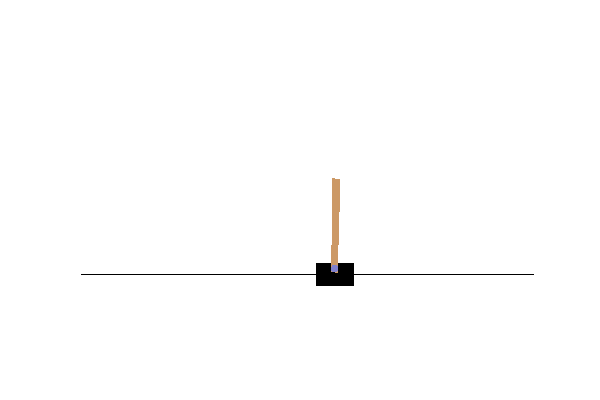
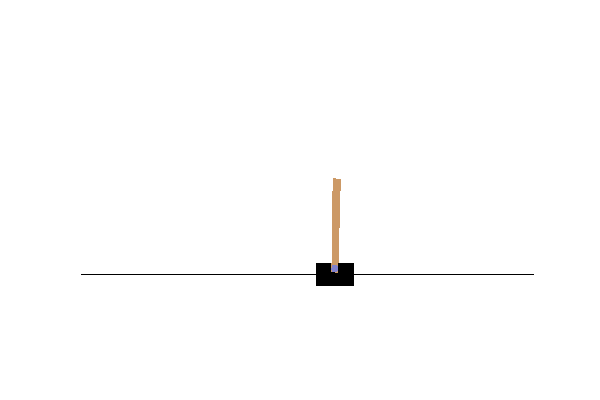
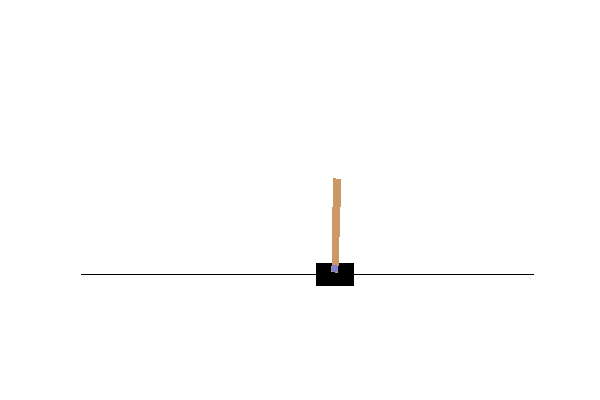
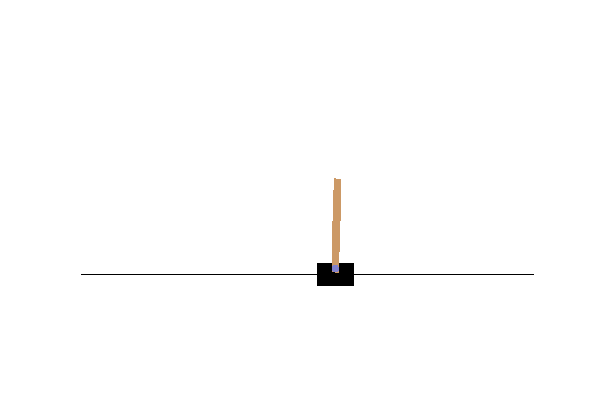
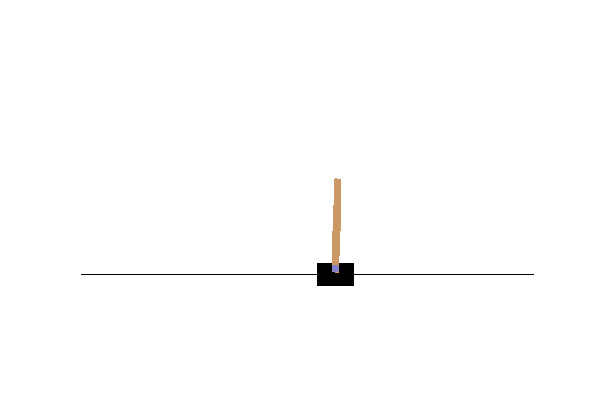
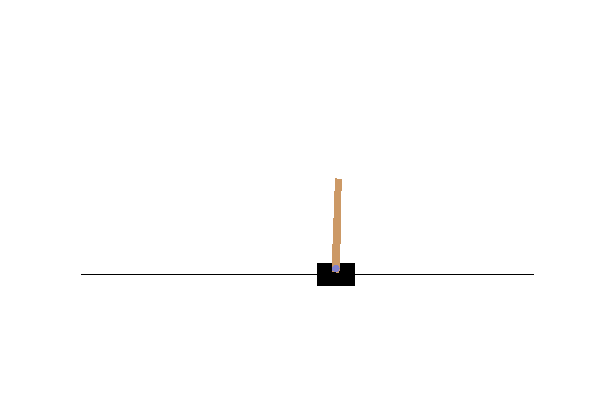
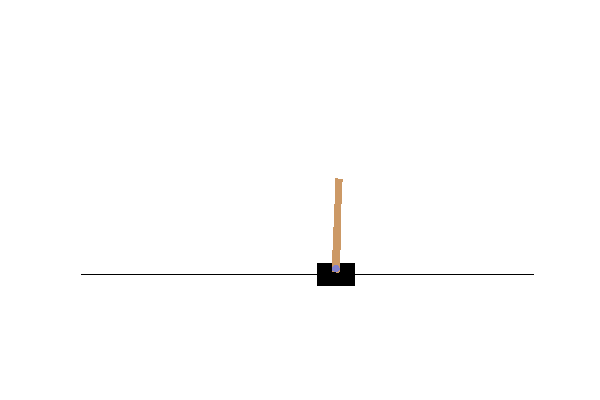
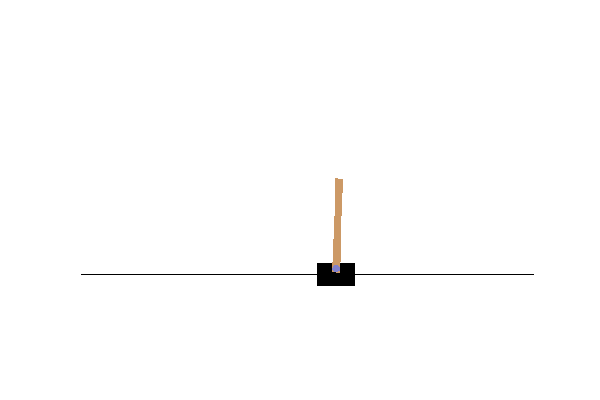
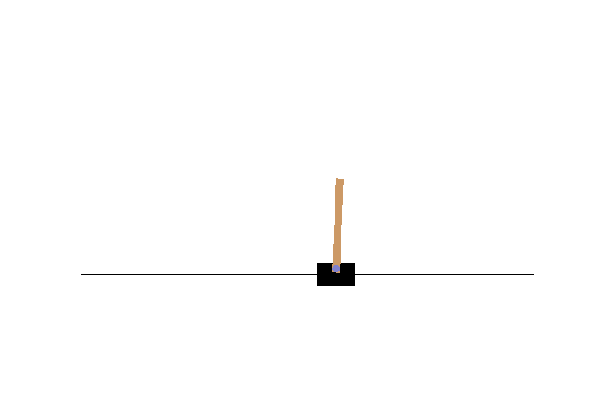
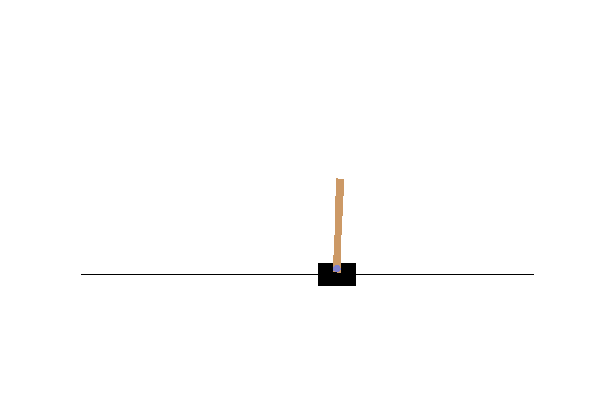
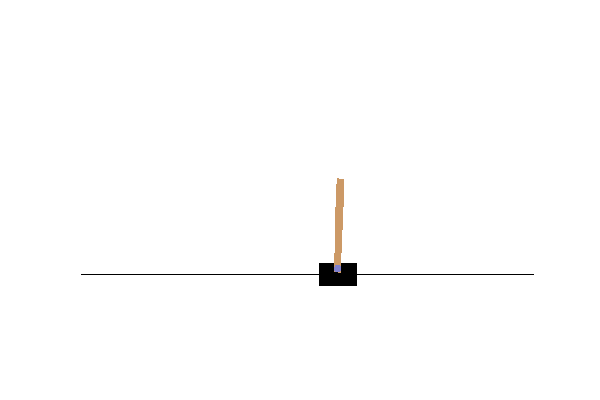
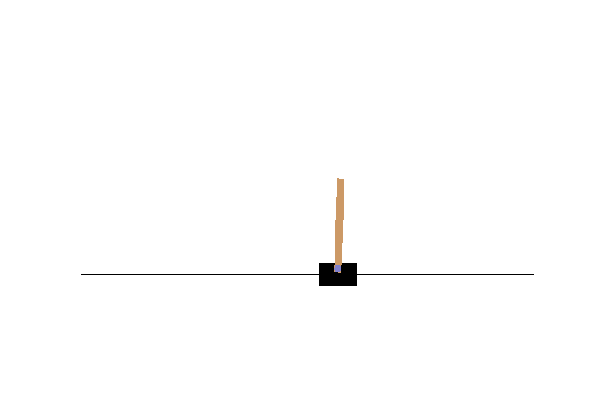
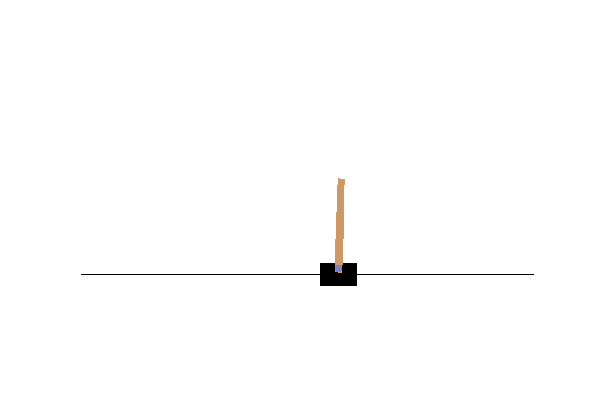
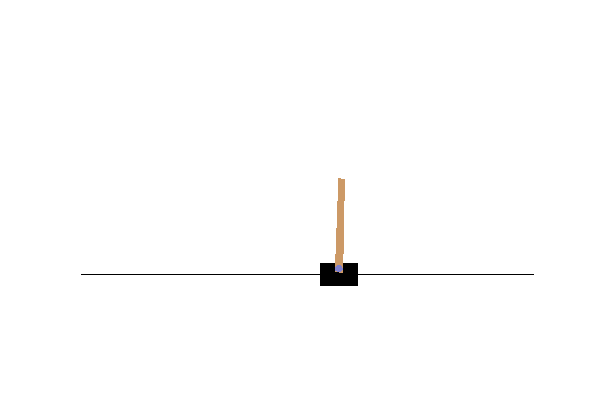
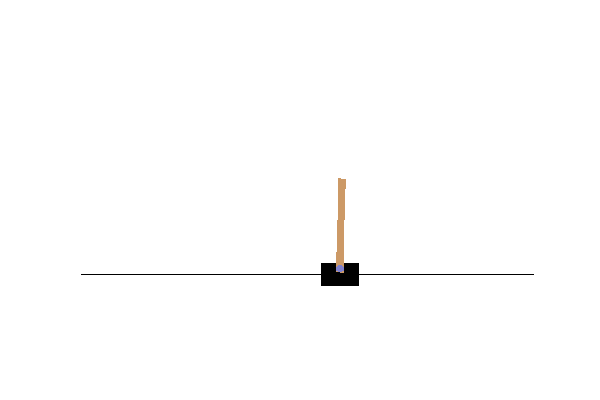
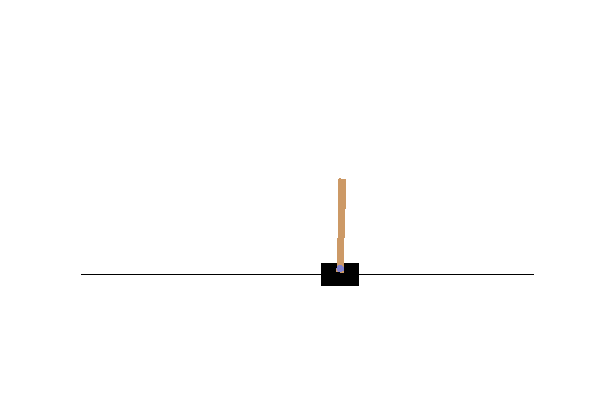
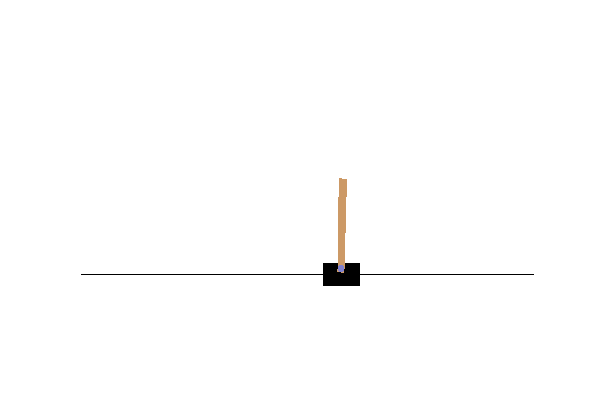
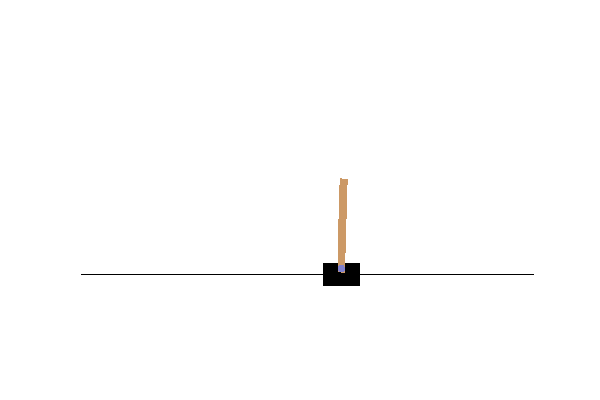
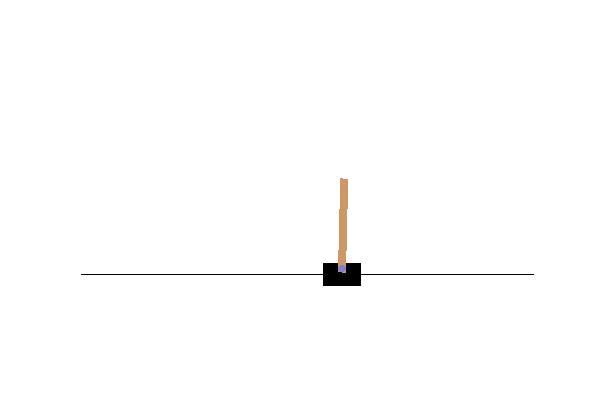
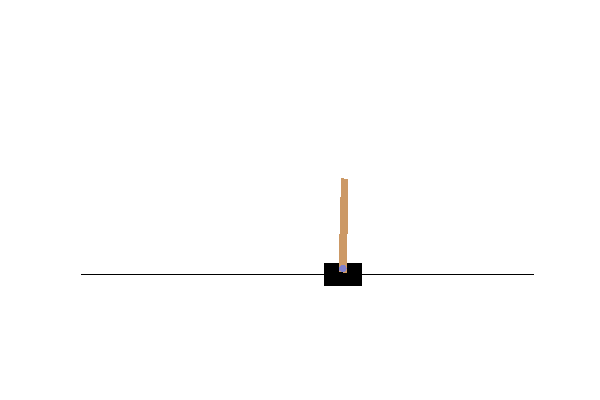
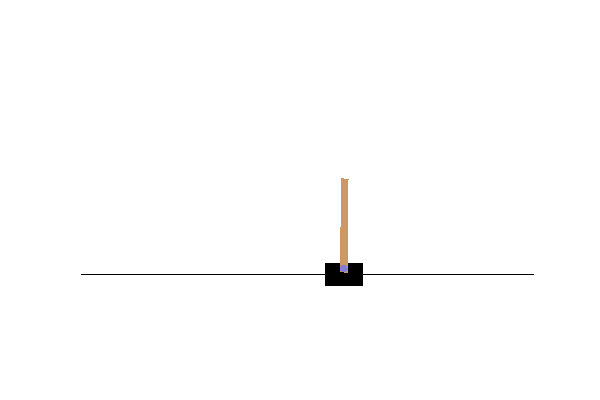
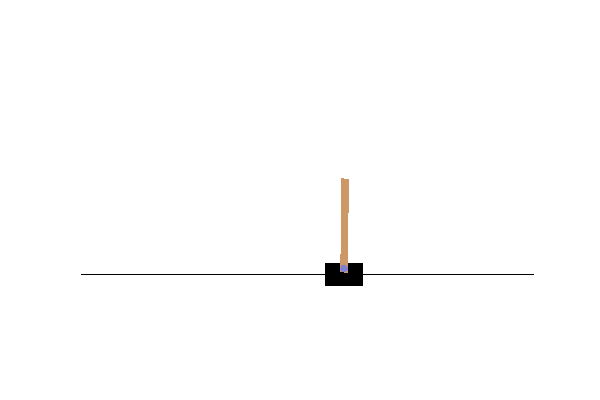
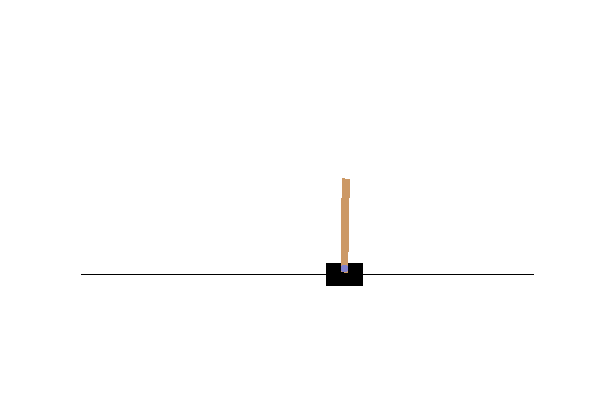
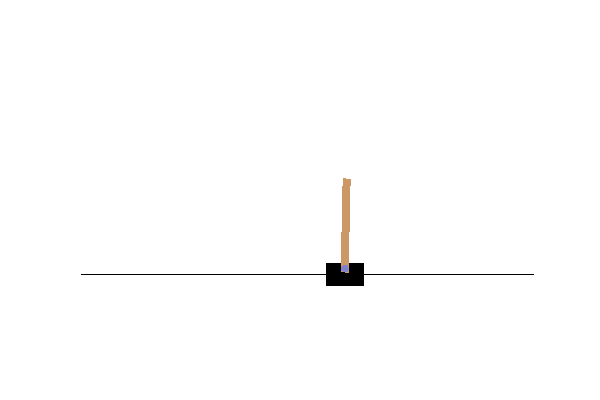
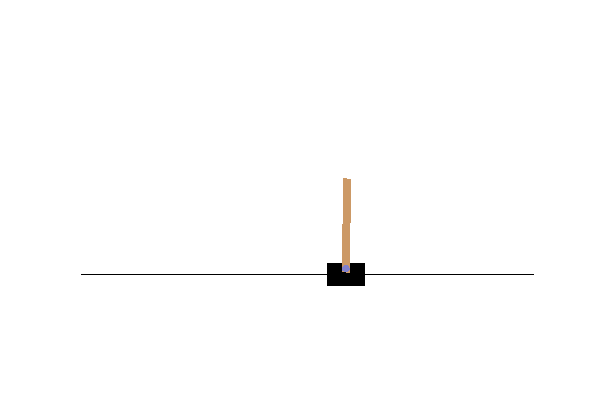
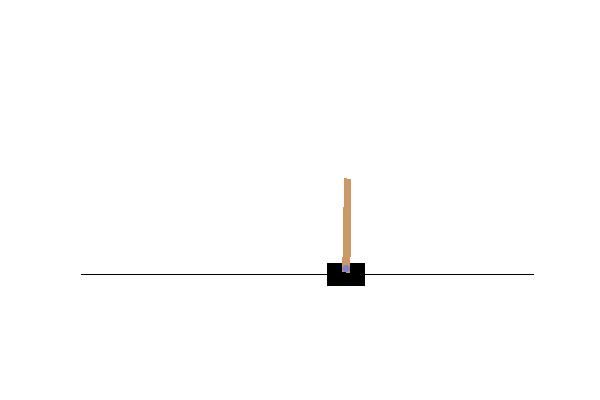
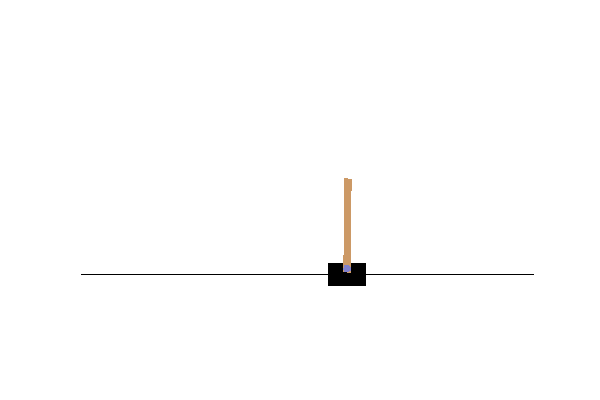

In [11]:
cartpole_env = Environment()
cartpole_env.run()